https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
import pandas as pd
import re

In [4]:
# Read the CSV file into a pandas DataFrame
df = pd.read_csv('dataset/cso_clean.csv')
df.head()

,003.01,003.02,003.03,003.04,003.05,003.06,003.07,003.08,003.09,003.10,003.11,003.12,003.13,003.14,003.15,003.16,003.17,combined
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,safe seismic friendly house project sigi centr...
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,safe seismic friendly house project sigi centr...
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,locally led disaster preparedness and protecti...
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,locally led disaster preparedness and protecti...
4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,locally led disaster preparedness and protecti...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2445 entries, 0 to 2444
Data columns (total 18 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   003.01    2445 non-null   int64 
 1   003.02    2445 non-null   int64 
 2   003.03    2445 non-null   int64 
 3   003.04    2445 non-null   int64 
 4   003.05    2445 non-null   int64 
 5   003.06    2445 non-null   int64 
 6   003.07    2445 non-null   int64 
 7   003.08    2445 non-null   int64 
 8   003.09    2445 non-null   int64 
 9   003.10    2445 non-null   int64 
 10  003.11    2445 non-null   int64 
 11  003.12    2445 non-null   int64 
 12  003.13    2445 non-null   int64 
 13  003.14    2445 non-null   int64 
 14  003.15    2445 non-null   int64 
 15  003.16    2445 non-null   int64 
 16  003.17    2445 non-null   int64 
 17  combined  2445 non-null   object
dtypes: int64(17), object(1)
memory usage: 344.0+ KB


In [6]:
df['combined'][600]

'pemberdayaan difabel. bantuan modal usaha. jumlah difable yang dibantu. dana zis dan csr'

In [7]:
# Define a function to clean the text
def clean_text(text):
    cleaned_text = text.lower()
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text.strip())
    cleaned_text = re.sub(r'\d+', '', cleaned_text)
    cleaned_text = re.sub(r'\.[a-zA-Z]{2}', '', cleaned_text)
    cleaned_text = cleaned_text.replace("-", " ")
    cleaned_text = ' '.join(cleaned_text.split())
    
    return cleaned_text

# Apply the cleaning function to the 'Text' column
df['combined'] = df['combined'].apply(clean_text)

In [8]:
df['combined'][100] 

'pengawasan dan pendataan produksi nelayan. pengawasan swadaya nelayan dalam mencegah iuu fishing. patroli bersama antara pengawas swadaya dan aparatur keamanan dalam memberantas iuu fishing. missing'

# Checking English Content

In [9]:
from langdetect import detect_langs
from collections import Counter

In [10]:
# Create an empty counter for languages
language_counter = Counter()


# Define a function to detect languages with a threshold
def detect_languages_with_threshold(text, threshold=0.7):
    languages = detect_langs(text)
    for lang in languages:
        if lang.prob >= threshold:
            language_counter[lang.lang] += 1

# Apply the detect_languages_with_threshold function to your dataset column
df['combined'].apply(detect_languages_with_threshold)

# Print the language distribution
print("Language Distribution:")
for lang, count in language_counter.items():
    print(f"{lang}: {count}")

Language Distribution:
id: 2229
en: 152
et: 3
fr: 1
es: 1
af: 2


In [11]:
y_columns = list(set(df.columns.array) - set(['combined']))
y_columns 

['003.07',
 '003.17',
 '003.01',
 '003.02',
 '003.13',
 '003.09',
 '003.16',
 '003.03',
 '003.10',
 '003.15',
 '003.08',
 '003.11',
 '003.05',
 '003.14',
 '003.06',
 '003.04',
 '003.12']

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import gc

2024-08-08 13:04:29.196587: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-08 13:04:31.181498: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [13]:
df2 = df.copy()

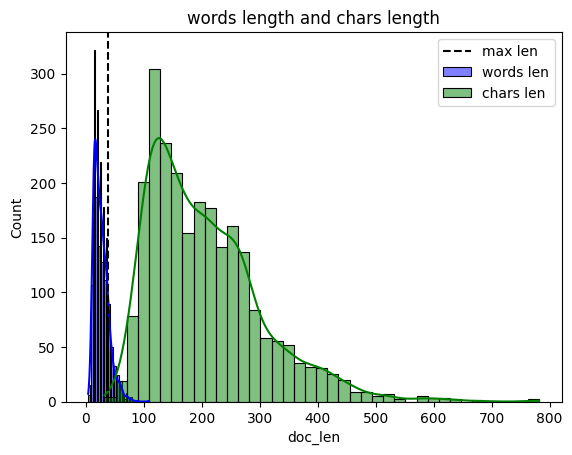

In [14]:
#visualize word distribution
df2['doc_len'] = df2['combined'].apply(lambda words: len(words.split(" ")))
df2['char_len'] = df2['combined'].apply(lambda words: len(words))
max_seq_len = np.round(df2['doc_len'].mean() + df2['doc_len'].std()).astype(int)

fig, ax = plt.subplots()
sns.histplot(df2, x='doc_len', kde=True, color='b', label='words len')
sns.histplot(df2, x='char_len', kde=True, color='g', label='chars len')

plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('words length and chars length'); 
plt.legend()
plt.show()

In [15]:
# Calculate min, max, and average word length
min_word_len = df2['doc_len'].min()
max_word_len = df2['doc_len'].max()
avg_word_len = df2['doc_len'].mean()

print("Minimum word length:", min_word_len)
print("Maximum word length:", max_word_len)
print("Average word length:", avg_word_len)

Minimum word length: 4
Maximum word length: 109
Average word length: 26.132106339468304


In [16]:
#df.to_csv("sdgs_clean.csv")

In [17]:
X = df['combined'].copy()
y = df[y_columns].copy()

In [18]:
X.head()

0    safe seismic friendly house project sigi centr...
1    safe seismic friendly house project sigi centr...
2    locally led disaster preparedness and protecti...
3    locally led disaster preparedness and protecti...
4    locally led disaster preparedness and protecti...
Name: combined, dtype: object

In [19]:
y.head()

,003.07,003.17,003.01,003.02,003.13,003.09,003.16,003.03,003.10,003.15,003.08,003.11,003.05,003.14,003.06,003.04,003.12
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [20]:
labels = [label for label in df.keys() if label not in ['combined']]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}
labels

['003.01',
 '003.02',
 '003.03',
 '003.04',
 '003.05',
 '003.06',
 '003.07',
 '003.08',
 '003.09',
 '003.10',
 '003.11',
 '003.12',
 '003.13',
 '003.14',
 '003.15',
 '003.16',
 '003.17']

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2445 entries, 0 to 2444
Data columns (total 18 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   003.01    2445 non-null   int64 
 1   003.02    2445 non-null   int64 
 2   003.03    2445 non-null   int64 
 3   003.04    2445 non-null   int64 
 4   003.05    2445 non-null   int64 
 5   003.06    2445 non-null   int64 
 6   003.07    2445 non-null   int64 
 7   003.08    2445 non-null   int64 
 8   003.09    2445 non-null   int64 
 9   003.10    2445 non-null   int64 
 10  003.11    2445 non-null   int64 
 11  003.12    2445 non-null   int64 
 12  003.13    2445 non-null   int64 
 13  003.14    2445 non-null   int64 
 14  003.15    2445 non-null   int64 
 15  003.16    2445 non-null   int64 
 16  003.17    2445 non-null   int64 
 17  combined  2445 non-null   object
dtypes: int64(17), object(1)
memory usage: 344.0+ KB


In [22]:
from transformers import AutoTokenizer
import numpy as np
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification

from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
import torch

In [23]:

import re
def train_test_sdgs(model_name,dir_name,ds, epoch=2, report_to=None, save_to=None):
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    def preprocess_data(examples):
        # take a batch of texts
        text = examples["combined"]
        
        # encode them
        encoding = tokenizer(text, padding="max_length", truncation=True, max_length=128)
        # add labels
        labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
        # create numpy array of shape (batch_size, num_labels)
        labels_matrix = np.zeros((len(text), len(labels)))
        # fill numpy array
        for idx, label in enumerate(labels):
            labels_matrix[:, idx] = labels_batch[label]

        encoding["labels"] = labels_matrix.tolist()
        
        return encoding
    
    # source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
    def multi_label_metrics(predictions, labels, threshold=0.5):
        # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
        sigmoid = torch.nn.Sigmoid()
        probs = sigmoid(torch.Tensor(predictions))
        # next, use threshold to turn them into integer predictions
        y_pred = np.zeros(probs.shape)
        y_pred[np.where(probs >= threshold)] = 1
        # finally, compute metrics
        y_true = labels
        f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
        f1_macro_average = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
        roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
        accuracy = accuracy_score(y_true, y_pred)
        # return as dictionary
        metrics = {'f1_micro': f1_micro_average,
                'f1_macro': f1_macro_average,
                'roc_auc': roc_auc,
                'accuracy': accuracy}
        return metrics
    
    def compute_metrics(p: EvalPrediction):
        preds = p.predictions[0] if isinstance(p.predictions, 
                tuple) else p.predictions
        result = multi_label_metrics(
            predictions=preds, 
            labels=p.label_ids)
        return result
    
    batch_size = 64
    metric_name = "f1_macro"
    
    encoded_dataset = ds.map(preprocess_data, batched=True, remove_columns=ds['train'].column_names)
    encoded_dataset.set_format("torch")
    
    args = TrainingArguments(
        dir_name,
        evaluation_strategy = "epoch",
        save_strategy = "epoch",
        save_total_limit=1,
        learning_rate=5e-5,
        #optim='adamw_torch', 
        #lr_scheduler_type='linear',
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epoch,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model=metric_name,
        report_to=report_to,  # Use wandb for reporting
        do_train=True,
        do_eval=True,
        #push_to_hub=True,
    )
    
    model = AutoModelForSequenceClassification.from_pretrained(model_name, 
                                                        problem_type="multi_label_classification", 
                                                        num_labels=len(labels),
                                                        id2label=id2label,
                                                        label2id=label2id)
    
    trainer = Trainer(
        model,
        args,
        train_dataset=encoded_dataset["train"],
        #test_dataset=encoded_dataset["test"],
        eval_dataset=encoded_dataset["valid"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics

    )
    
    trainer.train()
    print("Start Evaluation")
    evaluation_result = trainer.evaluate() #encoded_dataset["test"])
    print(evaluation_result)
    
    #if save_to is not None:
    #    trainer.save_model(save_to) 
    
    return evaluation_result


In [24]:
from datasets import *
dataset = Dataset.from_pandas(df)
from sklearn.model_selection import KFold

In [25]:
train_testvalid = dataset.train_test_split(test_size=0.4)
# Split the 10% test + valid in half test, half valid
test_valid = train_testvalid['test'].train_test_split(test_size=0.2)
# gather everyone if you want to have a single DatasetDict
ds = DatasetDict({
    'train': test_valid['train'],
    'valid': test_valid['test'],
    'test': train_testvalid['train']})

In [26]:
ds

DatasetDict({
    train: Dataset({
        features: ['003.01', '003.02', '003.03', '003.04', '003.05', '003.06', '003.07', '003.08', '003.09', '003.10', '003.11', '003.12', '003.13', '003.14', '003.15', '003.16', '003.17', 'combined'],
        num_rows: 782
    })
    valid: Dataset({
        features: ['003.01', '003.02', '003.03', '003.04', '003.05', '003.06', '003.07', '003.08', '003.09', '003.10', '003.11', '003.12', '003.13', '003.14', '003.15', '003.16', '003.17', 'combined'],
        num_rows: 196
    })
    test: Dataset({
        features: ['003.01', '003.02', '003.03', '003.04', '003.05', '003.06', '003.07', '003.08', '003.09', '003.10', '003.11', '003.12', '003.13', '003.14', '003.15', '003.16', '003.17', 'combined'],
        num_rows: 1467
    })
})

In [27]:
binary_values = [ds['train'][key] for key in ds['train'].column_names if key.startswith('003.')]


In [28]:
for row in ds['train']:
    binary_values = [row[key] for key in row if key.startswith('003.')]
    print(binary_values)

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1]
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0,

In [29]:
dataset

Dataset({
    features: ['003.01', '003.02', '003.03', '003.04', '003.05', '003.06', '003.07', '003.08', '003.09', '003.10', '003.11', '003.12', '003.13', '003.14', '003.15', '003.16', '003.17', 'combined'],
    num_rows: 2445
})

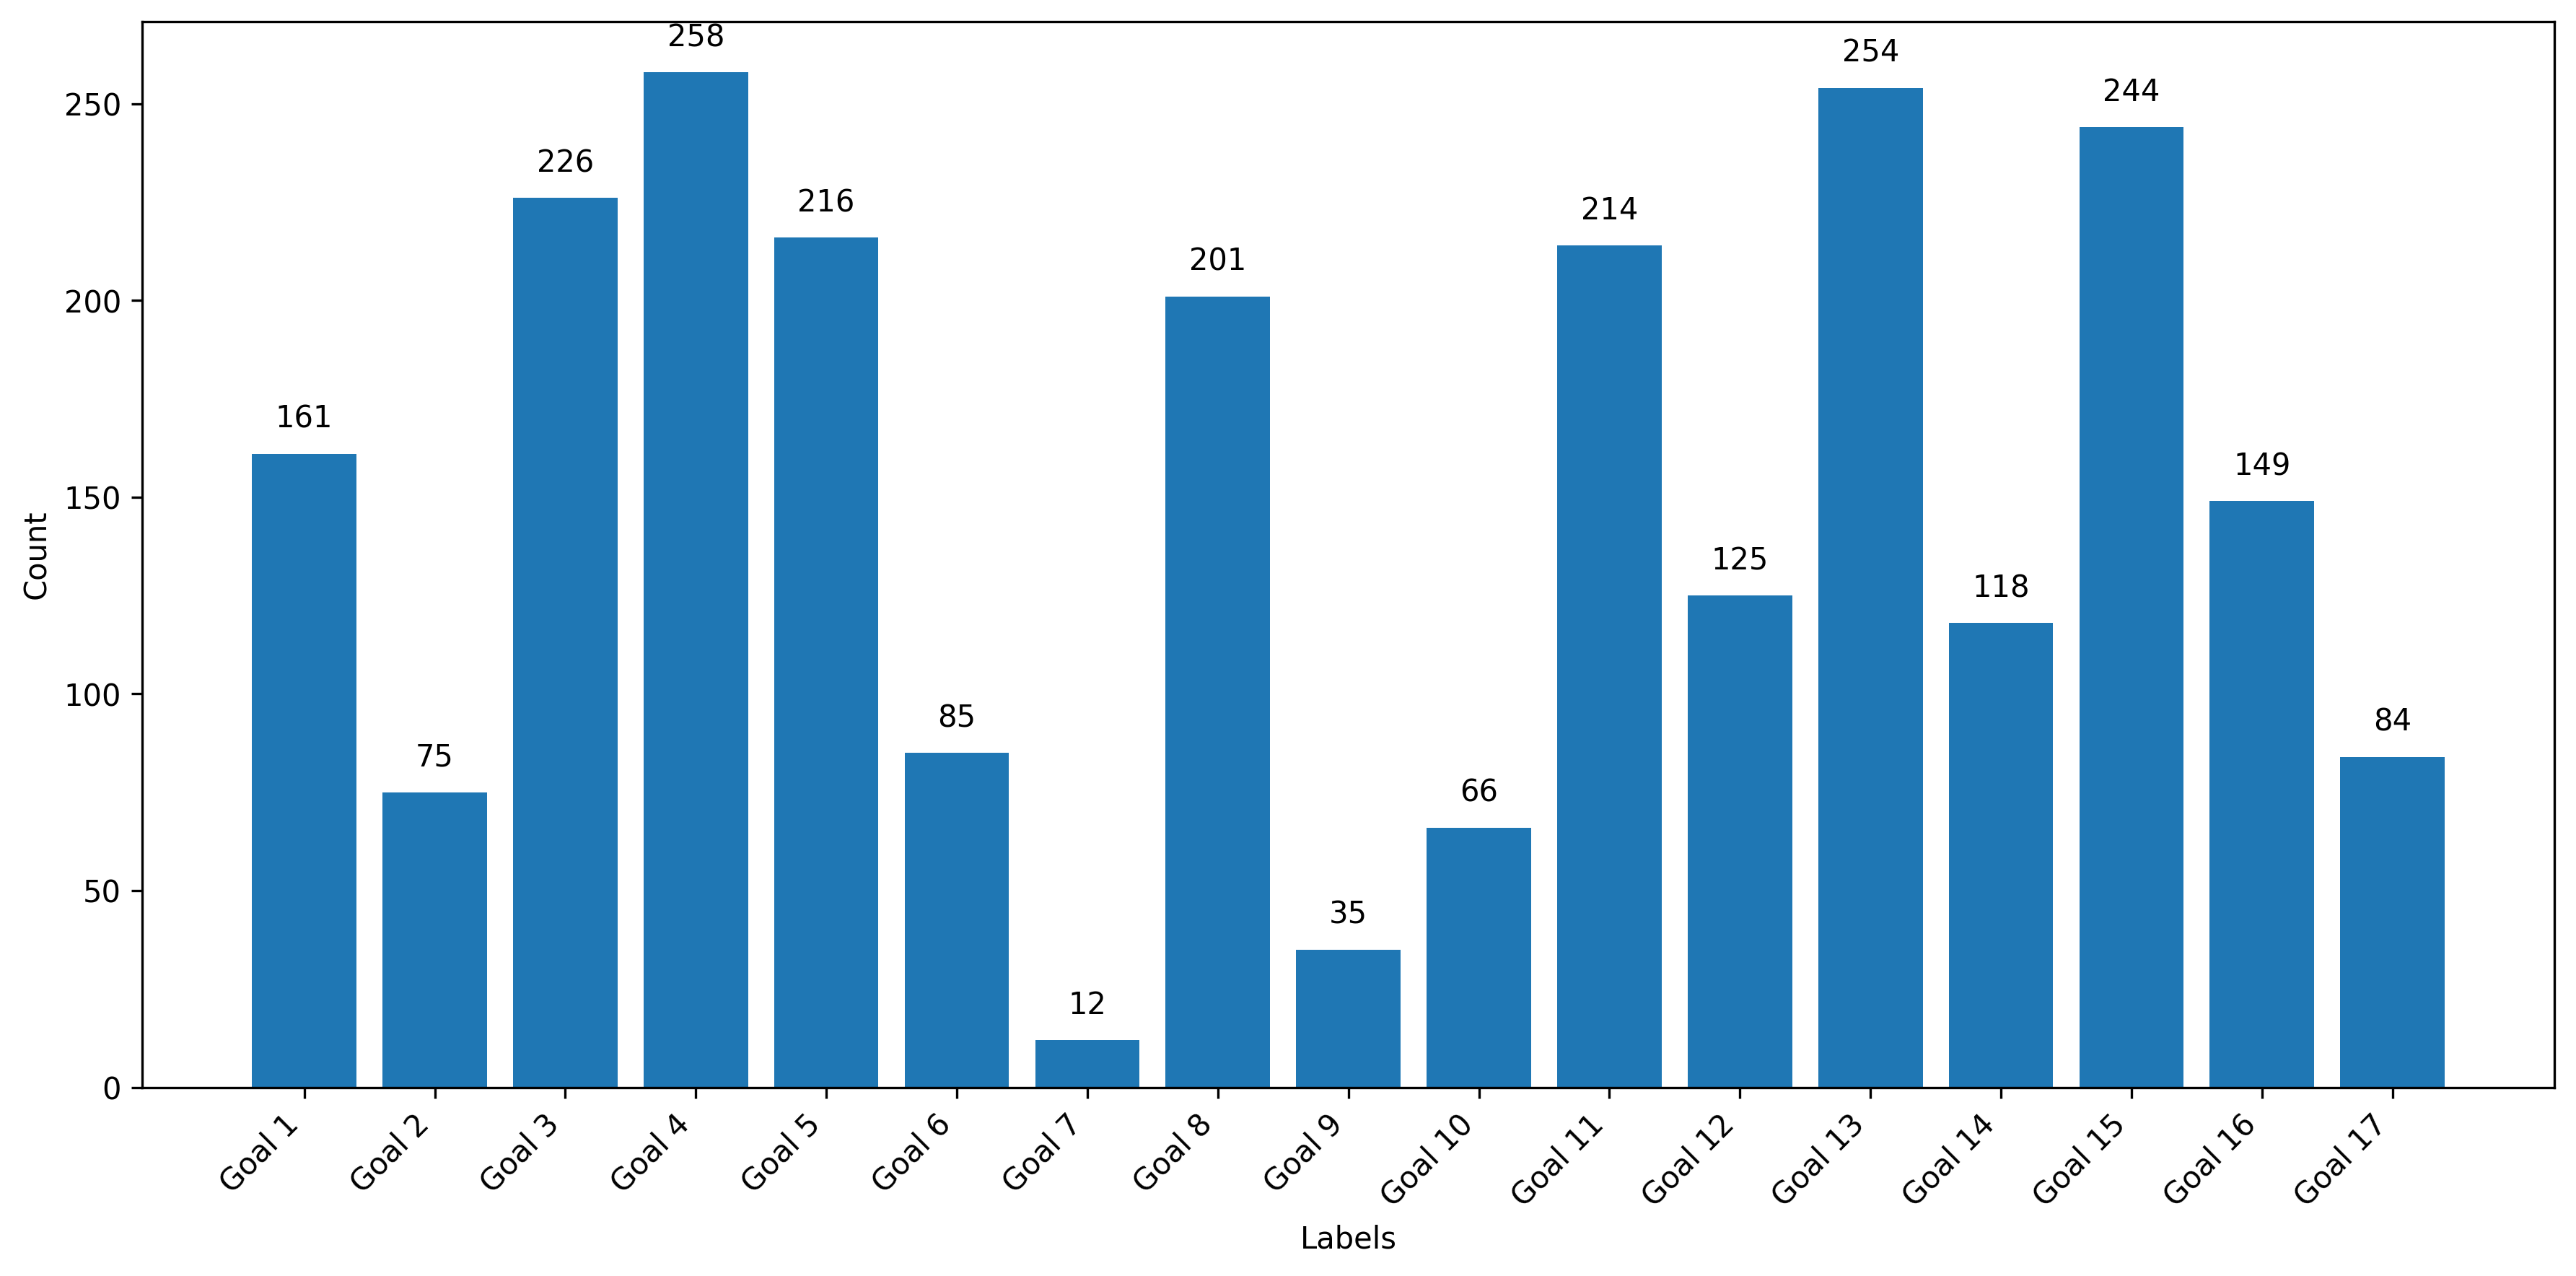

In [31]:
# Filter out the 'combined' feature and keep only numerical features
numerical_features = [feature for feature in dataset.features if feature != 'combined']

# Calculate the count of value 1 for each feature
count_of_ones = [np.sum(dataset[feature]) for feature in numerical_features]

# # Format the numerical feature names as '001', '002', '003', etc.
formatted_feature_names = [f"Goal {str(i + 1)}" for i in range(len(numerical_features))]

# plt.bar(formatted_feature_names, count_of_ones)
# plt.title("Label Distribution")
# plt.xlabel("Labels")
# plt.ylabel("Counts")

# plt.xticks(rotation=45, ha="right")
# plt.tight_layout()

# # Manually set the DPI when displaying the plot
# plt.gcf().set_dpi(300)

# plt.show()

# Create a bar plot
plt.figure(figsize=(12, 6),dpi=300)
bars = plt.bar(formatted_feature_names, count_of_ones)

# Add count labels on top of each bar
for bar, count in zip(bars, count_of_ones):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, str(count), ha='center', va='bottom')

#plt.bar(formatted_feature_names, count_of_ones)
#plt.title("Label Distribution")
plt.xlabel("Labels")
plt.ylabel("Count")

plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Manually set the DPI when displaying the plot
plt.gcf().set_dpi(300)

plt.show()

In [76]:
def train_sdgs_kfold_real3(my_dataset, models):
    hasil1 = []
    hasil2 = []
    
    # Initialize KFold with 5 splits
    folds = KFold(n_splits=5, random_state=42, shuffle=True)
    splits = folds.split(np.zeros(my_dataset.num_rows))
    n=1
    for train_idxs, val_idxs in splits:
        ds = DatasetDict({
            'train': my_dataset.select(train_idxs),
            'valid': my_dataset.select(val_idxs)})
        print(ds)
        
        print("model 1-", n)
        hasil1.append(train_test_sdgs(models[0],
                    f"models/model1-{n}",ds,15))
        
        print("model 2-", n)
        hasil2.append(train_test_sdgs(models[1],
                    f"models/model2-{n}",ds,15))
        
        
        n+=1
    print(hasil1,hasil2)
    return hasil1,hasil2

In [77]:
import scipy.stats as stats


In [78]:
def draw_comparison_pvalue(list_hasil, ylabel, width=10):
    fig,ax = plt.subplots(dpi=300)
    fig.set_figwidth(width)

    for i,(key,value) in enumerate(list_hasil.items()):
        if (i==0):
            to_compare = value
        else:
            data = [to_compare, value]
            t_stat, p_value = stats.ttest_ind(to_compare, value)
            x_pos = i  # X-coordinate position of the p-value text
            y_pos = np.max(np.concatenate(data))  # Y-coordinate position of the p-value text
            plt.text(x_pos, y_pos, f'p-value = {p_value:.4f}', ha='center')
            print(data)

        print(i,key,value)
        ax.boxplot(value,positions=[i])

    plt.xticks([i for i in range(len(list_hasil))], list_hasil.keys())
    ax.set_ylabel(ylabel=ylabel)
    ax.set_xlabel("Models")
    plt.show()

In [88]:
def draw_comparison(list_hasil, ylabel, width=10, height=4):
    fig,ax = plt.subplots(dpi=300)
    fig.set_figwidth(width)
    fig.set_figheight(height)

    for i,(key,value) in enumerate(list_hasil.items()):
        if (i==0):
            to_compare = value
        else:
            data = [to_compare, value]
            t_stat, p_value = stats.ttest_ind(to_compare, value)
            x_pos = i  # X-coordinate position of the p-value text
            y_pos = np.max(np.concatenate(data))  # Y-coordinate position of the p-value text
            #plt.text(x_pos, y_pos, f'p-value = {p_value:.4f}', ha='center')
            #print(data)

        print(i,key,value)
        ax.boxplot(value,positions=[i], showmeans=True, meanprops={"marker": "+",
                       "markeredgecolor": "black",
                       "markersize": "5"})

    plt.xticks([i for i in range(len(list_hasil))], list_hasil.keys())
    ax.set_ylabel(ylabel=ylabel)
    ax.set_xlabel("Models")
    #ax.grid()
    plt.show()

In [80]:
def grab_roc_auc(list_model,n_item):
    hasil=[]
    for x in range(n_item):
        hasil.append(list_model[x]["eval_roc_auc"])
    return hasil

In [81]:
def grab_f1_macro(list_model,n_item):
    hasil=[]
    for x in range(n_item):
        hasil.append(list_model[x]["eval_f1_macro"])
    return hasil

In [82]:
import wandb
wandb.init(project="huggingface")


eval/accuracy,▁▆▆▁▁▁▁▇▇▁▁▁▁▅▅▁▁▁▁▆▆▁▁▁▁██▁▁▁
eval/f1_macro,▁▆▆▁▁▁▁▇▇▁▁▁▁▅▅▁▁▁▁▆▆▁▁▁▁██▁▁▁
eval/f1_micro,▁▆▆▁▁▁▁▇▇▁▁▁▁▅▅▁▁▁▁▆▆▁▁▁▁██▁▁▁
eval/loss,▄▁▁█▆█▄▁▁█▆█▄▁▁█▆█▄▁▁█▆█▄▁▁█▆█
eval/roc_auc,▁▆▆▁▁▁▁▇▇▁▁▁▁▅▅▁▁▁▁▆▆▁▁▁▁██▁▁▁
eval/runtime,▃▆▃▃▅▅▄▅▂▄█▃▄▂▅▅█▅▂▄▂▁▆▄▄▄▄▇▄▅
eval/samples_per_second,▅▃▆▅▄▄▅▄▇▄▁▆▅▇▄▄▁▄▇▅▇█▃▅▅▄▅▂▅▄
eval/steps_per_second,▅▃▆▅▄▄▅▄▇▄▁▆▅▇▄▄▁▄▇▅▇█▃▅▅▄▅▂▅▄
train/epoch,▁███▁███▁███▁███▁███▁███▁███▁███▁███▁███
train/global_step,▁███▁███▁███▁███▁███▁███▁███▁███▁███▁███
train/total_flos,▁▁▁▁▁▁▁▁▁▁


# Final 25

In [83]:
import pandas as pd

def print_summary(models_data,digit=2):
    # Initialize lists to store averages for each model
    model_names = []
    model_accuracies = []
    model_f1_macros = []
    model_f1_micros = []

    # Calculate averages for each model
    for idx, model_data in enumerate(models_data):
        accuracy = sum(d['eval_accuracy'] for d in model_data) / len(model_data)
        f1_macro = sum(d['eval_f1_macro'] for d in model_data) / len(model_data)
        f1_micro = sum(d['eval_f1_micro'] for d in model_data) / len(model_data)
        model_names.append(f"Model {idx+1}")
        model_accuracies.append(accuracy)
        model_f1_macros.append(f1_macro)
        model_f1_micros.append(f1_micro)

    # Create a DataFrame to summarize the averages
    summary_df = pd.DataFrame({
        'Model': model_names,
        'Accuracy': [round(acc, digit) for acc in model_accuracies],
        'F1 Macro': [round(f1_macro, digit) for f1_macro in model_f1_macros],
        'F1 Micro': [round(f1_micro, digit) for f1_micro in model_f1_micros]
    })

    print(summary_df)


# Compare 2

In [84]:
models_25 = [
            "../../script/IndoGovBERT-final/models/persuratan-final-25/",
            "bert-base-multilingual-uncased",
            ]
y25_1,y25_2 = train_sdgs_kfold_real3(dataset, models_25)

DatasetDict({
    train: Dataset({
        features: ['003.01', '003.02', '003.03', '003.04', '003.05', '003.06', '003.07', '003.08', '003.09', '003.10', '003.11', '003.12', '003.13', '003.14', '003.15', '003.16', '003.17', 'combined'],
        num_rows: 1956
    })
    valid: Dataset({
        features: ['003.01', '003.02', '003.03', '003.04', '003.05', '003.06', '003.07', '003.08', '003.09', '003.10', '003.11', '003.12', '003.13', '003.14', '003.15', '003.16', '003.17', 'combined'],
        num_rows: 489
    })
})
model 1- 1


Map:   0%|          | 0/1956 [00:00<?, ? examples/s]

Map:   0%|          | 0/489 [00:00<?, ? examples/s]

Some weights of the model checkpoint at ../../script/IndoGovBERT-final/models/persuratan-final-25/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

  0%|          | 0/465 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.19629687070846558, 'eval_f1_micro': 0.11524163568773232, 'eval_f1_macro': 0.04502541757443718, 'eval_roc_auc': 0.5305683659794519, 'eval_accuracy': 0.06339468302658487, 'eval_runtime': 0.4771, 'eval_samples_per_second': 1024.902, 'eval_steps_per_second': 16.767, 'epoch': 1.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.12646952271461487, 'eval_f1_micro': 0.5795148247978437, 'eval_f1_macro': 0.3571250307867568, 'eval_roc_auc': 0.7111056460427982, 'eval_accuracy': 0.4212678936605317, 'eval_runtime': 0.4453, 'eval_samples_per_second': 1098.169, 'eval_steps_per_second': 17.966, 'epoch': 2.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.08956844359636307, 'eval_f1_micro': 0.7950727883538634, 'eval_f1_macro': 0.6096581347021917, 'eval_roc_auc': 0.8487410710262554, 'eval_accuracy': 0.7075664621676891, 'eval_runtime': 0.444, 'eval_samples_per_second': 1101.422, 'eval_steps_per_second': 18.019, 'epoch': 3.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.07213140279054642, 'eval_f1_micro': 0.8553191489361702, 'eval_f1_macro': 0.7144094108128869, 'eval_roc_auc': 0.8951837587732909, 'eval_accuracy': 0.7995910020449898, 'eval_runtime': 0.4948, 'eval_samples_per_second': 988.266, 'eval_steps_per_second': 16.168, 'epoch': 4.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.06085817143321037, 'eval_f1_micro': 0.8664563617245005, 'eval_f1_macro': 0.7255059896592974, 'eval_roc_auc': 0.9050011366104503, 'eval_accuracy': 0.8179959100204499, 'eval_runtime': 0.4451, 'eval_samples_per_second': 1098.53, 'eval_steps_per_second': 17.972, 'epoch': 5.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.05647412687540054, 'eval_f1_micro': 0.8748707342295761, 'eval_f1_macro': 0.8131416423720956, 'eval_roc_auc': 0.9155504763891327, 'eval_accuracy': 0.8445807770961146, 'eval_runtime': 0.4388, 'eval_samples_per_second': 1114.522, 'eval_steps_per_second': 18.233, 'epoch': 6.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.051932163536548615, 'eval_f1_micro': 0.8831967213114753, 'eval_f1_macro': 0.8283707598634878, 'eval_roc_auc': 0.9233915696413121, 'eval_accuracy': 0.852760736196319, 'eval_runtime': 0.4308, 'eval_samples_per_second': 1135.018, 'eval_steps_per_second': 18.569, 'epoch': 7.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.05177652835845947, 'eval_f1_micro': 0.8701973001038421, 'eval_f1_macro': 0.7478668929070402, 'eval_roc_auc': 0.9115979072191723, 'eval_accuracy': 0.8343558282208589, 'eval_runtime': 0.4547, 'eval_samples_per_second': 1075.522, 'eval_steps_per_second': 17.595, 'epoch': 8.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.04877758398652077, 'eval_f1_micro': 0.8807339449541285, 'eval_f1_macro': 0.840102373003775, 'eval_roc_auc': 0.9241235315828351, 'eval_accuracy': 0.8650306748466258, 'eval_runtime': 0.4445, 'eval_samples_per_second': 1100.128, 'eval_steps_per_second': 17.998, 'epoch': 9.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.04640289023518562, 'eval_f1_micro': 0.882051282051282, 'eval_f1_macro': 0.8375417764771916, 'eval_roc_auc': 0.922403427348822, 'eval_accuracy': 0.8548057259713702, 'eval_runtime': 0.4496, 'eval_samples_per_second': 1087.666, 'eval_steps_per_second': 17.794, 'epoch': 10.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.04530516266822815, 'eval_f1_micro': 0.8864097363083164, 'eval_f1_macro': 0.8458533535035152, 'eval_roc_auc': 0.9290642430452858, 'eval_accuracy': 0.8629856850715747, 'eval_runtime': 0.4325, 'eval_samples_per_second': 1130.587, 'eval_steps_per_second': 18.496, 'epoch': 11.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.04526907578110695, 'eval_f1_micro': 0.8846153846153846, 'eval_f1_macro': 0.8441719783756019, 'eval_roc_auc': 0.9289361528698022, 'eval_accuracy': 0.8711656441717791, 'eval_runtime': 0.4481, 'eval_samples_per_second': 1091.311, 'eval_steps_per_second': 17.854, 'epoch': 12.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.04417147487401962, 'eval_f1_micro': 0.8864097363083164, 'eval_f1_macro': 0.8481971576576258, 'eval_roc_auc': 0.9290642430452858, 'eval_accuracy': 0.8650306748466258, 'eval_runtime': 0.4531, 'eval_samples_per_second': 1079.261, 'eval_steps_per_second': 17.657, 'epoch': 13.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.04395631328225136, 'eval_f1_micro': 0.888888888888889, 'eval_f1_macro': 0.8523514623854243, 'eval_roc_auc': 0.9319646248350143, 'eval_accuracy': 0.8732106339468303, 'eval_runtime': 0.4403, 'eval_samples_per_second': 1110.666, 'eval_steps_per_second': 18.17, 'epoch': 14.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.04392527788877487, 'eval_f1_micro': 0.8897876643073812, 'eval_f1_macro': 0.8540273464142496, 'eval_roc_auc': 0.932028669922756, 'eval_accuracy': 0.8732106339468303, 'eval_runtime': 0.4243, 'eval_samples_per_second': 1152.614, 'eval_steps_per_second': 18.857, 'epoch': 15.0}
{'train_runtime': 252.4317, 'train_samples_per_second': 116.229, 'train_steps_per_second': 1.842, 'train_loss': 0.06647565698110929, 'epoch': 15.0}
Start Evaluation


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.04392527788877487, 'eval_f1_micro': 0.8897876643073812, 'eval_f1_macro': 0.8540273464142496, 'eval_roc_auc': 0.932028669922756, 'eval_accuracy': 0.8732106339468303, 'eval_runtime': 0.4284, 'eval_samples_per_second': 1141.42, 'eval_steps_per_second': 18.674, 'epoch': 15.0}
model 2- 1


Map:   0%|          | 0/1956 [00:00<?, ? examples/s]

Map:   0%|          | 0/489 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingu

  0%|          | 0/465 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.24050617218017578, 'eval_f1_micro': 0.0, 'eval_f1_macro': 0.0, 'eval_roc_auc': 0.5, 'eval_accuracy': 0.0, 'eval_runtime': 0.4446, 'eval_samples_per_second': 1099.779, 'eval_steps_per_second': 17.992, 'epoch': 1.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.21417322754859924, 'eval_f1_micro': 0.0, 'eval_f1_macro': 0.0, 'eval_roc_auc': 0.5, 'eval_accuracy': 0.0, 'eval_runtime': 0.4312, 'eval_samples_per_second': 1134.144, 'eval_steps_per_second': 18.554, 'epoch': 2.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.18854793906211853, 'eval_f1_micro': 0.0, 'eval_f1_macro': 0.0, 'eval_roc_auc': 0.49993595491225823, 'eval_accuracy': 0.0, 'eval_runtime': 0.4579, 'eval_samples_per_second': 1068.008, 'eval_steps_per_second': 17.473, 'epoch': 3.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.1567826271057129, 'eval_f1_micro': 0.41832061068702286, 'eval_f1_macro': 0.1737243579696963, 'eval_roc_auc': 0.634606953018245, 'eval_accuracy': 0.2719836400817996, 'eval_runtime': 0.4314, 'eval_samples_per_second': 1133.514, 'eval_steps_per_second': 18.544, 'epoch': 4.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.12564730644226074, 'eval_f1_micro': 0.639580602883355, 'eval_f1_macro': 0.37495469332134007, 'eval_roc_auc': 0.7402741332269458, 'eval_accuracy': 0.48261758691206547, 'eval_runtime': 0.4404, 'eval_samples_per_second': 1110.432, 'eval_steps_per_second': 18.167, 'epoch': 5.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.10327112674713135, 'eval_f1_micro': 0.790011350737798, 'eval_f1_macro': 0.5255985111707974, 'eval_roc_auc': 0.8421443004175335, 'eval_accuracy': 0.6789366053169734, 'eval_runtime': 0.4417, 'eval_samples_per_second': 1107.174, 'eval_steps_per_second': 18.113, 'epoch': 6.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.0881853923201561, 'eval_f1_micro': 0.8617363344051446, 'eval_f1_macro': 0.6557660366005853, 'eval_roc_auc': 0.8956320743874834, 'eval_accuracy': 0.7934560327198364, 'eval_runtime': 0.437, 'eval_samples_per_second': 1118.977, 'eval_steps_per_second': 18.306, 'epoch': 7.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.07636954635381699, 'eval_f1_micro': 0.882290562036055, 'eval_f1_macro': 0.7106473215015809, 'eval_roc_auc': 0.9097222468333123, 'eval_accuracy': 0.8302658486707567, 'eval_runtime': 0.4433, 'eval_samples_per_second': 1103.107, 'eval_steps_per_second': 18.047, 'epoch': 8.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.07103317230939865, 'eval_f1_micro': 0.8904958677685951, 'eval_f1_macro': 0.7520049518541994, 'eval_roc_auc': 0.9239039303432461, 'eval_accuracy': 0.8507157464212679, 'eval_runtime': 0.4413, 'eval_samples_per_second': 1108.147, 'eval_steps_per_second': 18.129, 'epoch': 9.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.06510305404663086, 'eval_f1_micro': 0.9022869022869023, 'eval_f1_macro': 0.7674397770182748, 'eval_roc_auc': 0.9274447630103925, 'eval_accuracy': 0.8568507157464212, 'eval_runtime': 0.4422, 'eval_samples_per_second': 1105.861, 'eval_steps_per_second': 18.092, 'epoch': 10.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.0613328292965889, 'eval_f1_micro': 0.8895705521472392, 'eval_f1_macro': 0.7578749120769867, 'eval_roc_auc': 0.9274722289867562, 'eval_accuracy': 0.8588957055214724, 'eval_runtime': 0.4445, 'eval_samples_per_second': 1100.081, 'eval_steps_per_second': 17.997, 'epoch': 11.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.05820131674408913, 'eval_f1_micro': 0.9070247933884297, 'eval_f1_macro': 0.7734882995887785, 'eval_roc_auc': 0.9323214293851014, 'eval_accuracy': 0.869120654396728, 'eval_runtime': 0.4273, 'eval_samples_per_second': 1144.462, 'eval_steps_per_second': 18.723, 'epoch': 12.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.05694081261754036, 'eval_f1_micro': 0.8984615384615384, 'eval_f1_macro': 0.7712918568348032, 'eval_roc_auc': 0.9308209263906769, 'eval_accuracy': 0.8650306748466258, 'eval_runtime': 0.4524, 'eval_samples_per_second': 1080.858, 'eval_steps_per_second': 17.683, 'epoch': 13.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.05579943209886551, 'eval_f1_micro': 0.9034907597535933, 'eval_f1_macro': 0.7765277671709482, 'eval_roc_auc': 0.9329893462388824, 'eval_accuracy': 0.869120654396728, 'eval_runtime': 0.4305, 'eval_samples_per_second': 1135.854, 'eval_steps_per_second': 18.582, 'epoch': 14.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.055429618805646896, 'eval_f1_micro': 0.9014373716632443, 'eval_f1_macro': 0.7733876024788342, 'eval_roc_auc': 0.9319371588586508, 'eval_accuracy': 0.8670756646216768, 'eval_runtime': 0.4695, 'eval_samples_per_second': 1041.643, 'eval_steps_per_second': 17.041, 'epoch': 15.0}
{'train_runtime': 311.2964, 'train_samples_per_second': 94.251, 'train_steps_per_second': 1.494, 'train_loss': 0.12168535622217322, 'epoch': 15.0}
Start Evaluation


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.05579943209886551, 'eval_f1_micro': 0.9034907597535933, 'eval_f1_macro': 0.7765277671709482, 'eval_roc_auc': 0.9329893462388824, 'eval_accuracy': 0.869120654396728, 'eval_runtime': 0.4346, 'eval_samples_per_second': 1125.186, 'eval_steps_per_second': 18.408, 'epoch': 15.0}
DatasetDict({
    train: Dataset({
        features: ['003.01', '003.02', '003.03', '003.04', '003.05', '003.06', '003.07', '003.08', '003.09', '003.10', '003.11', '003.12', '003.13', '003.14', '003.15', '003.16', '003.17', 'combined'],
        num_rows: 1956
    })
    valid: Dataset({
        features: ['003.01', '003.02', '003.03', '003.04', '003.05', '003.06', '003.07', '003.08', '003.09', '003.10', '003.11', '003.12', '003.13', '003.14', '003.15', '003.16', '003.17', 'combined'],
        num_rows: 489
    })
})
model 1- 2


Map:   0%|          | 0/1956 [00:00<?, ? examples/s]

Map:   0%|          | 0/489 [00:00<?, ? examples/s]

Some weights of the model checkpoint at ../../script/IndoGovBERT-final/models/persuratan-final-25/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

  0%|          | 0/465 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.20362719893455505, 'eval_f1_micro': 0.046783625730994156, 'eval_f1_macro': 0.026637069922308545, 'eval_roc_auc': 0.5119760479041916, 'eval_accuracy': 0.024539877300613498, 'eval_runtime': 0.4335, 'eval_samples_per_second': 1127.911, 'eval_steps_per_second': 18.453, 'epoch': 1.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.13778240978717804, 'eval_f1_micro': 0.5209840810419681, 'eval_f1_macro': 0.3586169196887765, 'eval_roc_auc': 0.6790006776002526, 'eval_accuracy': 0.3496932515337423, 'eval_runtime': 0.4441, 'eval_samples_per_second': 1101.173, 'eval_steps_per_second': 18.015, 'epoch': 2.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.09603201597929001, 'eval_f1_micro': 0.7567567567567568, 'eval_f1_macro': 0.5983744395760359, 'eval_roc_auc': 0.8195651707338012, 'eval_accuracy': 0.6359918200408998, 'eval_runtime': 0.4453, 'eval_samples_per_second': 1098.148, 'eval_steps_per_second': 17.966, 'epoch': 3.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.07611784338951111, 'eval_f1_micro': 0.8442534908700323, 'eval_f1_macro': 0.7284727820816937, 'eval_roc_auc': 0.8898474173005755, 'eval_accuracy': 0.7791411042944786, 'eval_runtime': 0.4353, 'eval_samples_per_second': 1123.441, 'eval_steps_per_second': 18.379, 'epoch': 4.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.0680835023522377, 'eval_f1_micro': 0.8349307774227902, 'eval_f1_macro': 0.7244165816853004, 'eval_roc_auc': 0.8882733764422002, 'eval_accuracy': 0.7770961145194274, 'eval_runtime': 0.4471, 'eval_samples_per_second': 1093.693, 'eval_steps_per_second': 17.893, 'epoch': 5.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.06052546948194504, 'eval_f1_micro': 0.8574401664932361, 'eval_f1_macro': 0.7890259622365293, 'eval_roc_auc': 0.908105448089995, 'eval_accuracy': 0.8159509202453987, 'eval_runtime': 0.4459, 'eval_samples_per_second': 1096.772, 'eval_steps_per_second': 17.943, 'epoch': 6.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.06045448035001755, 'eval_f1_micro': 0.8586171310629515, 'eval_f1_macro': 0.8020526613087767, 'eval_roc_auc': 0.9118414476730103, 'eval_accuracy': 0.8261758691206544, 'eval_runtime': 0.432, 'eval_samples_per_second': 1132.031, 'eval_steps_per_second': 18.52, 'epoch': 7.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.05567410960793495, 'eval_f1_micro': 0.8488612836438924, 'eval_f1_macro': 0.8383658894556243, 'eval_roc_auc': 0.905661411432128, 'eval_accuracy': 0.8118609406952966, 'eval_runtime': 0.4432, 'eval_samples_per_second': 1103.459, 'eval_steps_per_second': 18.052, 'epoch': 8.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.0531865693628788, 'eval_f1_micro': 0.8556701030927836, 'eval_f1_macro': 0.8553789551642189, 'eval_roc_auc': 0.91071543548847, 'eval_accuracy': 0.820040899795501, 'eval_runtime': 0.4555, 'eval_samples_per_second': 1073.51, 'eval_steps_per_second': 17.563, 'epoch': 9.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.05269533023238182, 'eval_f1_micro': 0.8565573770491803, 'eval_f1_macro': 0.8583578501409701, 'eval_roc_auc': 0.9135174351757315, 'eval_accuracy': 0.8282208588957055, 'eval_runtime': 0.445, 'eval_samples_per_second': 1098.857, 'eval_steps_per_second': 17.977, 'epoch': 10.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.05272011458873749, 'eval_f1_micro': 0.8562628336755648, 'eval_f1_macro': 0.8587517974085204, 'eval_roc_auc': 0.9125834352799777, 'eval_accuracy': 0.8282208588957055, 'eval_runtime': 0.4369, 'eval_samples_per_second': 1119.359, 'eval_steps_per_second': 18.313, 'epoch': 11.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.05329262465238571, 'eval_f1_micro': 0.8524590163934427, 'eval_f1_macro': 0.8547329868105812, 'eval_roc_auc': 0.9113934189991753, 'eval_accuracy': 0.8261758691206544, 'eval_runtime': 0.4397, 'eval_samples_per_second': 1112.166, 'eval_steps_per_second': 18.195, 'epoch': 12.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.051594723016023636, 'eval_f1_micro': 0.8556806550665301, 'eval_f1_macro': 0.8584965381912975, 'eval_roc_auc': 0.9134534310794692, 'eval_accuracy': 0.8302658486707567, 'eval_runtime': 0.4515, 'eval_samples_per_second': 1082.983, 'eval_steps_per_second': 17.718, 'epoch': 13.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.051254529505968094, 'eval_f1_micro': 0.8536335721596725, 'eval_f1_macro': 0.8545916466989157, 'eval_roc_auc': 0.9123914229911912, 'eval_accuracy': 0.8282208588957055, 'eval_runtime': 0.4575, 'eval_samples_per_second': 1068.778, 'eval_steps_per_second': 17.485, 'epoch': 14.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.0513557530939579, 'eval_f1_micro': 0.8536335721596725, 'eval_f1_macro': 0.8550357267699685, 'eval_roc_auc': 0.9123914229911912, 'eval_accuracy': 0.8282208588957055, 'eval_runtime': 0.4583, 'eval_samples_per_second': 1066.916, 'eval_steps_per_second': 17.455, 'epoch': 15.0}
{'train_runtime': 245.4728, 'train_samples_per_second': 119.524, 'train_steps_per_second': 1.894, 'train_loss': 0.06613352375645791, 'epoch': 15.0}
Start Evaluation


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.05272011458873749, 'eval_f1_micro': 0.8562628336755648, 'eval_f1_macro': 0.8587517974085204, 'eval_roc_auc': 0.9125834352799777, 'eval_accuracy': 0.8282208588957055, 'eval_runtime': 0.4288, 'eval_samples_per_second': 1140.476, 'eval_steps_per_second': 18.658, 'epoch': 15.0}
model 2- 2


Map:   0%|          | 0/1956 [00:00<?, ? examples/s]

Map:   0%|          | 0/489 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingu

  0%|          | 0/465 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.23990395665168762, 'eval_f1_micro': 0.0, 'eval_f1_macro': 0.0, 'eval_roc_auc': 0.5, 'eval_accuracy': 0.0, 'eval_runtime': 0.4336, 'eval_samples_per_second': 1127.714, 'eval_steps_per_second': 18.449, 'epoch': 1.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.21148619055747986, 'eval_f1_micro': 0.0, 'eval_f1_macro': 0.0, 'eval_roc_auc': 0.5, 'eval_accuracy': 0.0, 'eval_runtime': 0.4382, 'eval_samples_per_second': 1115.956, 'eval_steps_per_second': 18.257, 'epoch': 2.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.18641556799411774, 'eval_f1_micro': 0.24390243902439027, 'eval_f1_macro': 0.1257375334454442, 'eval_roc_auc': 0.5696682671523313, 'eval_accuracy': 0.14314928425357873, 'eval_runtime': 0.4465, 'eval_samples_per_second': 1095.216, 'eval_steps_per_second': 17.918, 'epoch': 3.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.15767121315002441, 'eval_f1_micro': 0.4956268221574344, 'eval_f1_macro': 0.30340330078549194, 'eval_roc_auc': 0.6687006171987823, 'eval_accuracy': 0.33537832310838445, 'eval_runtime': 0.4391, 'eval_samples_per_second': 1113.539, 'eval_steps_per_second': 18.217, 'epoch': 4.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.13064493238925934, 'eval_f1_micro': 0.6361256544502618, 'eval_f1_macro': 0.43607648183026365, 'eval_roc_auc': 0.741234888134637, 'eval_accuracy': 0.4785276073619632, 'eval_runtime': 0.4338, 'eval_samples_per_second': 1127.292, 'eval_steps_per_second': 18.442, 'epoch': 5.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.11020048707723618, 'eval_f1_micro': 0.6817042606516291, 'eval_f1_macro': 0.44766796539061166, 'eval_roc_auc': 0.7698569834217894, 'eval_accuracy': 0.5419222903885481, 'eval_runtime': 0.4495, 'eval_samples_per_second': 1087.835, 'eval_steps_per_second': 17.797, 'epoch': 6.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.09967584162950516, 'eval_f1_micro': 0.7676767676767677, 'eval_f1_macro': 0.6007804317965666, 'eval_roc_auc': 0.8382451686488774, 'eval_accuracy': 0.6748466257668712, 'eval_runtime': 0.4341, 'eval_samples_per_second': 1126.411, 'eval_steps_per_second': 18.428, 'epoch': 7.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.08839595317840576, 'eval_f1_micro': 0.8122941822173436, 'eval_f1_macro': 0.6904491612525558, 'eval_roc_auc': 0.8667013131954218, 'eval_accuracy': 0.7321063394683026, 'eval_runtime': 0.4415, 'eval_samples_per_second': 1107.571, 'eval_steps_per_second': 18.12, 'epoch': 8.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.08158597350120544, 'eval_f1_micro': 0.8349307774227902, 'eval_f1_macro': 0.7316390849262213, 'eval_roc_auc': 0.8882733764422002, 'eval_accuracy': 0.7770961145194274, 'eval_runtime': 0.4362, 'eval_samples_per_second': 1121.047, 'eval_steps_per_second': 18.34, 'epoch': 9.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.0774315819144249, 'eval_f1_micro': 0.8317460317460316, 'eval_f1_macro': 0.7237009103868979, 'eval_roc_auc': 0.8889513599529053, 'eval_accuracy': 0.7791411042944786, 'eval_runtime': 0.4522, 'eval_samples_per_second': 1081.395, 'eval_steps_per_second': 17.692, 'epoch': 10.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.07669853419065475, 'eval_f1_micro': 0.8317460317460316, 'eval_f1_macro': 0.7279889065772467, 'eval_roc_auc': 0.8889513599529053, 'eval_accuracy': 0.7791411042944786, 'eval_runtime': 0.4474, 'eval_samples_per_second': 1092.88, 'eval_steps_per_second': 17.879, 'epoch': 11.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.0729038417339325, 'eval_f1_micro': 0.8347280334728033, 'eval_f1_macro': 0.7330686109900846, 'eval_roc_auc': 0.8946193634236902, 'eval_accuracy': 0.7914110429447853, 'eval_runtime': 0.4444, 'eval_samples_per_second': 1100.317, 'eval_steps_per_second': 18.001, 'epoch': 12.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.07126539200544357, 'eval_f1_micro': 0.8368200836820083, 'eval_f1_macro': 0.7323343627607047, 'eval_roc_auc': 0.8956813715119684, 'eval_accuracy': 0.7934560327198364, 'eval_runtime': 0.4433, 'eval_samples_per_second': 1103.12, 'eval_steps_per_second': 18.047, 'epoch': 13.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.06927341222763062, 'eval_f1_micro': 0.8361344537815126, 'eval_f1_macro': 0.7348991041921087, 'eval_roc_auc': 0.8938133717204608, 'eval_accuracy': 0.7893660531697342, 'eval_runtime': 0.4453, 'eval_samples_per_second': 1098.241, 'eval_steps_per_second': 17.967, 'epoch': 14.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.06962575763463974, 'eval_f1_micro': 0.8350730688935283, 'eval_f1_macro': 0.7360637305899268, 'eval_roc_auc': 0.895553363319444, 'eval_accuracy': 0.7934560327198364, 'eval_runtime': 0.447, 'eval_samples_per_second': 1094.005, 'eval_steps_per_second': 17.898, 'epoch': 15.0}
{'train_runtime': 303.6443, 'train_samples_per_second': 96.626, 'train_steps_per_second': 1.531, 'train_loss': 0.11659129153015793, 'epoch': 15.0}
Start Evaluation


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.06962575763463974, 'eval_f1_micro': 0.8350730688935283, 'eval_f1_macro': 0.7360637305899268, 'eval_roc_auc': 0.895553363319444, 'eval_accuracy': 0.7934560327198364, 'eval_runtime': 0.435, 'eval_samples_per_second': 1124.171, 'eval_steps_per_second': 18.391, 'epoch': 15.0}
DatasetDict({
    train: Dataset({
        features: ['003.01', '003.02', '003.03', '003.04', '003.05', '003.06', '003.07', '003.08', '003.09', '003.10', '003.11', '003.12', '003.13', '003.14', '003.15', '003.16', '003.17', 'combined'],
        num_rows: 1956
    })
    valid: Dataset({
        features: ['003.01', '003.02', '003.03', '003.04', '003.05', '003.06', '003.07', '003.08', '003.09', '003.10', '003.11', '003.12', '003.13', '003.14', '003.15', '003.16', '003.17', 'combined'],
        num_rows: 489
    })
})
model 1- 3


Map:   0%|          | 0/1956 [00:00<?, ? examples/s]

Map:   0%|          | 0/489 [00:00<?, ? examples/s]

Some weights of the model checkpoint at ../../script/IndoGovBERT-final/models/persuratan-final-25/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

  0%|          | 0/465 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.2020108550786972, 'eval_f1_micro': 0.007889546351084813, 'eval_f1_macro': 0.004201680672268907, 'eval_roc_auc': 0.501980198019802, 'eval_accuracy': 0.00408997955010225, 'eval_runtime': 0.4461, 'eval_samples_per_second': 1096.128, 'eval_steps_per_second': 17.933, 'epoch': 1.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.1329512596130371, 'eval_f1_micro': 0.5775978407557355, 'eval_f1_macro': 0.3651022508206038, 'eval_roc_auc': 0.710472376643402, 'eval_accuracy': 0.4171779141104294, 'eval_runtime': 0.4439, 'eval_samples_per_second': 1101.586, 'eval_steps_per_second': 18.022, 'epoch': 2.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.09304210543632507, 'eval_f1_micro': 0.7936507936507937, 'eval_f1_macro': 0.6205414735064414, 'eval_roc_auc': 0.8448056575637072, 'eval_accuracy': 0.6850715746421268, 'eval_runtime': 0.4597, 'eval_samples_per_second': 1063.743, 'eval_steps_per_second': 17.403, 'epoch': 3.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.07343506813049316, 'eval_f1_micro': 0.8513368983957219, 'eval_f1_macro': 0.7090961889509056, 'eval_roc_auc': 0.8920102256127254, 'eval_accuracy': 0.7832310838445807, 'eval_runtime': 0.4448, 'eval_samples_per_second': 1099.41, 'eval_steps_per_second': 17.986, 'epoch': 4.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.0640861764550209, 'eval_f1_micro': 0.852910052910053, 'eval_f1_macro': 0.7363273496808893, 'eval_roc_auc': 0.8966405362360007, 'eval_accuracy': 0.7914110429447853, 'eval_runtime': 0.4395, 'eval_samples_per_second': 1112.573, 'eval_steps_per_second': 18.202, 'epoch': 5.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.05722043663263321, 'eval_f1_micro': 0.8672199170124482, 'eval_f1_macro': 0.7809788926257892, 'eval_roc_auc': 0.9112358738435318, 'eval_accuracy': 0.8220858895705522, 'eval_runtime': 0.4278, 'eval_samples_per_second': 1143.17, 'eval_steps_per_second': 18.702, 'epoch': 6.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.05300295725464821, 'eval_f1_micro': 0.8911704312114991, 'eval_f1_macro': 0.808141231546738, 'eval_roc_auc': 0.9274616793134232, 'eval_accuracy': 0.8548057259713702, 'eval_runtime': 0.4364, 'eval_samples_per_second': 1120.503, 'eval_steps_per_second': 18.331, 'epoch': 7.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.04990404099225998, 'eval_f1_micro': 0.8884339815762539, 'eval_f1_macro': 0.8159625300907587, 'eval_roc_auc': 0.9272695686576854, 'eval_accuracy': 0.8548057259713702, 'eval_runtime': 0.4369, 'eval_samples_per_second': 1119.37, 'eval_steps_per_second': 18.313, 'epoch': 8.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.04728962481021881, 'eval_f1_micro': 0.8837209302325582, 'eval_f1_macro': 0.8289790992347672, 'eval_roc_auc': 0.9296635337201752, 'eval_accuracy': 0.8568507157464212, 'eval_runtime': 0.4569, 'eval_samples_per_second': 1070.248, 'eval_steps_per_second': 17.509, 'epoch': 9.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.04545728862285614, 'eval_f1_micro': 0.8974619289340101, 'eval_f1_macro': 0.8549316406466986, 'eval_roc_auc': 0.9351903607368933, 'eval_accuracy': 0.8650306748466258, 'eval_runtime': 0.4645, 'eval_samples_per_second': 1052.673, 'eval_steps_per_second': 17.222, 'epoch': 10.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.04396753013134003, 'eval_f1_micro': 0.8927125506072874, 'eval_f1_macro': 0.8591051138661675, 'eval_roc_auc': 0.9339441141860088, 'eval_accuracy': 0.8670756646216768, 'eval_runtime': 0.4454, 'eval_samples_per_second': 1097.967, 'eval_steps_per_second': 17.963, 'epoch': 11.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.04411750286817551, 'eval_f1_micro': 0.8875379939209727, 'eval_f1_macro': 0.8567788264133498, 'eval_roc_auc': 0.9308457433858139, 'eval_accuracy': 0.8629856850715747, 'eval_runtime': 0.4676, 'eval_samples_per_second': 1045.699, 'eval_steps_per_second': 17.108, 'epoch': 12.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.043273620307445526, 'eval_f1_micro': 0.8897876643073811, 'eval_f1_macro': 0.8572159266770069, 'eval_roc_auc': 0.9328259414056159, 'eval_accuracy': 0.8670756646216768, 'eval_runtime': 0.4404, 'eval_samples_per_second': 1110.394, 'eval_steps_per_second': 18.166, 'epoch': 13.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.04354200139641762, 'eval_f1_micro': 0.8906882591093116, 'eval_f1_macro': 0.8590870095093083, 'eval_roc_auc': 0.9328899782908618, 'eval_accuracy': 0.8670756646216768, 'eval_runtime': 0.4566, 'eval_samples_per_second': 1071.011, 'eval_steps_per_second': 17.522, 'epoch': 14.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.04322677478194237, 'eval_f1_micro': 0.8884381338742393, 'eval_f1_macro': 0.8572658793355745, 'eval_roc_auc': 0.9309097802710599, 'eval_accuracy': 0.8629856850715747, 'eval_runtime': 0.4467, 'eval_samples_per_second': 1094.813, 'eval_steps_per_second': 17.911, 'epoch': 15.0}
{'train_runtime': 249.1152, 'train_samples_per_second': 117.777, 'train_steps_per_second': 1.867, 'train_loss': 0.06631592781313005, 'epoch': 15.0}
Start Evaluation


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.04396753013134003, 'eval_f1_micro': 0.8927125506072874, 'eval_f1_macro': 0.8591051138661675, 'eval_roc_auc': 0.9339441141860088, 'eval_accuracy': 0.8670756646216768, 'eval_runtime': 0.4478, 'eval_samples_per_second': 1091.939, 'eval_steps_per_second': 17.864, 'epoch': 15.0}
model 2- 3


Map:   0%|          | 0/1956 [00:00<?, ? examples/s]

Map:   0%|          | 0/489 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingu

  0%|          | 0/465 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.24037712812423706, 'eval_f1_micro': 0.0, 'eval_f1_macro': 0.0, 'eval_roc_auc': 0.5, 'eval_accuracy': 0.0, 'eval_runtime': 0.4451, 'eval_samples_per_second': 1098.732, 'eval_steps_per_second': 17.975, 'epoch': 1.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.21319130063056946, 'eval_f1_micro': 0.0, 'eval_f1_macro': 0.0, 'eval_roc_auc': 0.5, 'eval_accuracy': 0.0, 'eval_runtime': 0.4322, 'eval_samples_per_second': 1131.483, 'eval_steps_per_second': 18.511, 'epoch': 2.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.18638354539871216, 'eval_f1_micro': 0.23117338003502624, 'eval_f1_macro': 0.09852120976463297, 'eval_roc_auc': 0.5653465346534654, 'eval_accuracy': 0.13496932515337423, 'eval_runtime': 0.4228, 'eval_samples_per_second': 1156.607, 'eval_steps_per_second': 18.922, 'epoch': 3.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.15634854137897491, 'eval_f1_micro': 0.3765432098765432, 'eval_f1_macro': 0.15757116452593073, 'eval_roc_auc': 0.6194473046177569, 'eval_accuracy': 0.24948875255623723, 'eval_runtime': 0.4592, 'eval_samples_per_second': 1064.895, 'eval_steps_per_second': 17.422, 'epoch': 4.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.12578840553760529, 'eval_f1_micro': 0.6244952893674294, 'eval_f1_macro': 0.3915991769747986, 'eval_roc_auc': 0.7293187489855543, 'eval_accuracy': 0.4458077709611452, 'eval_runtime': 0.4501, 'eval_samples_per_second': 1086.478, 'eval_steps_per_second': 17.775, 'epoch': 5.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.10318829119205475, 'eval_f1_micro': 0.7723004694835681, 'eval_f1_macro': 0.5262144858023846, 'eval_roc_auc': 0.8245899103229996, 'eval_accuracy': 0.6421267893660532, 'eval_runtime': 0.4373, 'eval_samples_per_second': 1118.224, 'eval_steps_per_second': 18.294, 'epoch': 6.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.0898723304271698, 'eval_f1_micro': 0.8353591160220993, 'eval_f1_macro': 0.6405067467812392, 'eval_roc_auc': 0.8728486142671644, 'eval_accuracy': 0.7402862985685071, 'eval_runtime': 0.4365, 'eval_samples_per_second': 1120.317, 'eval_steps_per_second': 18.328, 'epoch': 7.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.07904801517724991, 'eval_f1_micro': 0.867237687366167, 'eval_f1_macro': 0.7198829169857245, 'eval_roc_auc': 0.8994532137639994, 'eval_accuracy': 0.7955010224948875, 'eval_runtime': 0.4403, 'eval_samples_per_second': 1110.706, 'eval_steps_per_second': 18.171, 'epoch': 8.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.07203437387943268, 'eval_f1_micro': 0.8807531380753139, 'eval_f1_macro': 0.7579876885952934, 'eval_roc_auc': 0.9149105766109398, 'eval_accuracy': 0.8282208588957055, 'eval_runtime': 0.4584, 'eval_samples_per_second': 1066.65, 'eval_steps_per_second': 17.45, 'epoch': 9.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.06755490601062775, 'eval_f1_micro': 0.886339937434828, 'eval_f1_macro': 0.7656227428331711, 'eval_roc_auc': 0.9189350095357894, 'eval_accuracy': 0.83640081799591, 'eval_runtime': 0.4314, 'eval_samples_per_second': 1133.624, 'eval_steps_per_second': 18.546, 'epoch': 10.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.06395333260297775, 'eval_f1_micro': 0.8872651356993737, 'eval_f1_macro': 0.7660649992902918, 'eval_roc_auc': 0.9189990464210355, 'eval_accuracy': 0.83640081799591, 'eval_runtime': 0.4392, 'eval_samples_per_second': 1113.51, 'eval_steps_per_second': 18.217, 'epoch': 11.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.06250268965959549, 'eval_f1_micro': 0.8790072388831438, 'eval_f1_macro': 0.7610481972501184, 'eval_roc_auc': 0.9184227144538223, 'eval_accuracy': 0.83640081799591, 'eval_runtime': 0.4477, 'eval_samples_per_second': 1092.327, 'eval_steps_per_second': 17.87, 'epoch': 12.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.06088338792324066, 'eval_f1_micro': 0.8836251287332646, 'eval_f1_macro': 0.7648587321234346, 'eval_roc_auc': 0.9223831104934263, 'eval_accuracy': 0.8445807770961146, 'eval_runtime': 0.429, 'eval_samples_per_second': 1139.985, 'eval_steps_per_second': 18.65, 'epoch': 13.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.06034357100725174, 'eval_f1_micro': 0.8841025641025642, 'eval_f1_macro': 0.7865357223625433, 'eval_roc_auc': 0.9242352347427365, 'eval_accuracy': 0.8486707566462167, 'eval_runtime': 0.4385, 'eval_samples_per_second': 1115.072, 'eval_steps_per_second': 18.242, 'epoch': 14.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.05953754112124443, 'eval_f1_micro': 0.8841025641025642, 'eval_f1_macro': 0.7972961240842076, 'eval_roc_auc': 0.9242352347427365, 'eval_accuracy': 0.8486707566462167, 'eval_runtime': 0.4295, 'eval_samples_per_second': 1138.561, 'eval_steps_per_second': 18.627, 'epoch': 15.0}
{'train_runtime': 304.3497, 'train_samples_per_second': 96.402, 'train_steps_per_second': 1.528, 'train_loss': 0.11884378412718415, 'epoch': 15.0}
Start Evaluation


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.05953754112124443, 'eval_f1_micro': 0.8841025641025642, 'eval_f1_macro': 0.7972961240842076, 'eval_roc_auc': 0.9242352347427365, 'eval_accuracy': 0.8486707566462167, 'eval_runtime': 0.4291, 'eval_samples_per_second': 1139.671, 'eval_steps_per_second': 18.645, 'epoch': 15.0}
DatasetDict({
    train: Dataset({
        features: ['003.01', '003.02', '003.03', '003.04', '003.05', '003.06', '003.07', '003.08', '003.09', '003.10', '003.11', '003.12', '003.13', '003.14', '003.15', '003.16', '003.17', 'combined'],
        num_rows: 1956
    })
    valid: Dataset({
        features: ['003.01', '003.02', '003.03', '003.04', '003.05', '003.06', '003.07', '003.08', '003.09', '003.10', '003.11', '003.12', '003.13', '003.14', '003.15', '003.16', '003.17', 'combined'],
        num_rows: 489
    })
})
model 1- 4


Map:   0%|          | 0/1956 [00:00<?, ? examples/s]

Map:   0%|          | 0/489 [00:00<?, ? examples/s]

Some weights of the model checkpoint at ../../script/IndoGovBERT-final/models/persuratan-final-25/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

  0%|          | 0/465 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.2008805274963379, 'eval_f1_micro': 0.0, 'eval_f1_macro': 0.0, 'eval_roc_auc': 0.5, 'eval_accuracy': 0.0, 'eval_runtime': 0.4258, 'eval_samples_per_second': 1148.305, 'eval_steps_per_second': 18.786, 'epoch': 1.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.1322333812713623, 'eval_f1_micro': 0.5725915875169606, 'eval_f1_macro': 0.3344769323304875, 'eval_roc_auc': 0.707566116498945, 'eval_accuracy': 0.41513292433537835, 'eval_runtime': 0.4571, 'eval_samples_per_second': 1069.736, 'eval_steps_per_second': 17.501, 'epoch': 2.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.09258899092674255, 'eval_f1_micro': 0.8083700440528635, 'eval_f1_macro': 0.6363349706862766, 'eval_roc_auc': 0.861061008764811, 'eval_accuracy': 0.721881390593047, 'eval_runtime': 0.4459, 'eval_samples_per_second': 1096.619, 'eval_steps_per_second': 17.941, 'epoch': 3.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.07464980334043503, 'eval_f1_micro': 0.8417653390742734, 'eval_f1_macro': 0.711990203741893, 'eval_roc_auc': 0.8850154956581724, 'eval_accuracy': 0.7689161554192229, 'eval_runtime': 0.4312, 'eval_samples_per_second': 1134.171, 'eval_steps_per_second': 18.555, 'epoch': 4.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.06364776939153671, 'eval_f1_micro': 0.8625792811839325, 'eval_f1_macro': 0.7450080567749284, 'eval_roc_auc': 0.9018471788264892, 'eval_accuracy': 0.8016359918200409, 'eval_runtime': 0.4457, 'eval_samples_per_second': 1097.158, 'eval_steps_per_second': 17.949, 'epoch': 5.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.05741933360695839, 'eval_f1_micro': 0.8779979144942649, 'eval_f1_macro': 0.7836061051582357, 'eval_roc_auc': 0.914718465955202, 'eval_accuracy': 0.8282208588957055, 'eval_runtime': 0.456, 'eval_samples_per_second': 1072.321, 'eval_steps_per_second': 17.543, 'epoch': 6.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.057076577097177505, 'eval_f1_micro': 0.8792569659442725, 'eval_f1_macro': 0.7886447344435955, 'eval_roc_auc': 0.9193487765784775, 'eval_accuracy': 0.83640081799591, 'eval_runtime': 0.4417, 'eval_samples_per_second': 1107.133, 'eval_steps_per_second': 18.113, 'epoch': 7.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.0521220825612545, 'eval_f1_micro': 0.8788501026694046, 'eval_f1_macro': 0.7890829233185793, 'eval_roc_auc': 0.9211368639425418, 'eval_accuracy': 0.83640081799591, 'eval_runtime': 0.4444, 'eval_samples_per_second': 1100.321, 'eval_steps_per_second': 18.001, 'epoch': 8.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.0498763844370842, 'eval_f1_micro': 0.878756476683938, 'eval_f1_macro': 0.8298786081488853, 'eval_roc_auc': 0.9174966523291672, 'eval_accuracy': 0.83640081799591, 'eval_runtime': 0.4395, 'eval_samples_per_second': 1112.594, 'eval_steps_per_second': 18.202, 'epoch': 9.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.04902871325612068, 'eval_f1_micro': 0.8870636550308009, 'eval_f1_macro': 0.838231976215691, 'eval_roc_auc': 0.9253534075231292, 'eval_accuracy': 0.852760736196319, 'eval_runtime': 0.4353, 'eval_samples_per_second': 1123.488, 'eval_steps_per_second': 18.38, 'epoch': 10.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.04771190136671066, 'eval_f1_micro': 0.8825331971399388, 'eval_f1_macro': 0.8341514276251012, 'eval_roc_auc': 0.9250332230968998, 'eval_accuracy': 0.8507157464212679, 'eval_runtime': 0.4564, 'eval_samples_per_second': 1071.46, 'eval_steps_per_second': 17.529, 'epoch': 11.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.046755384653806686, 'eval_f1_micro': 0.8836734693877552, 'eval_f1_macro': 0.8241563280880192, 'eval_roc_auc': 0.9260233221068008, 'eval_accuracy': 0.8507157464212679, 'eval_runtime': 0.4411, 'eval_samples_per_second': 1108.711, 'eval_steps_per_second': 18.138, 'epoch': 12.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.04632829129695892, 'eval_f1_micro': 0.8818088386433709, 'eval_f1_macro': 0.8368197032014624, 'eval_roc_auc': 0.9222550367229345, 'eval_accuracy': 0.8425357873210634, 'eval_runtime': 0.4473, 'eval_samples_per_second': 1093.122, 'eval_steps_per_second': 17.883, 'epoch': 13.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.04606343060731888, 'eval_f1_micro': 0.880245649948823, 'eval_f1_macro': 0.8351414934470959, 'eval_roc_auc': 0.9230530250770979, 'eval_accuracy': 0.8445807770961146, 'eval_runtime': 0.4375, 'eval_samples_per_second': 1117.781, 'eval_steps_per_second': 18.287, 'epoch': 14.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.04602810740470886, 'eval_f1_micro': 0.8781985670419652, 'eval_f1_macro': 0.8316330042801381, 'eval_roc_auc': 0.9219988891819509, 'eval_accuracy': 0.8404907975460123, 'eval_runtime': 0.4455, 'eval_samples_per_second': 1097.621, 'eval_steps_per_second': 17.957, 'epoch': 15.0}
{'train_runtime': 251.1412, 'train_samples_per_second': 116.827, 'train_steps_per_second': 1.852, 'train_loss': 0.06681409035959551, 'epoch': 15.0}
Start Evaluation


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.04902871325612068, 'eval_f1_micro': 0.8870636550308009, 'eval_f1_macro': 0.838231976215691, 'eval_roc_auc': 0.9253534075231292, 'eval_accuracy': 0.852760736196319, 'eval_runtime': 0.4457, 'eval_samples_per_second': 1097.056, 'eval_steps_per_second': 17.948, 'epoch': 15.0}
model 2- 4


Map:   0%|          | 0/1956 [00:00<?, ? examples/s]

Map:   0%|          | 0/489 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingu

  0%|          | 0/465 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.2402183711528778, 'eval_f1_micro': 0.0, 'eval_f1_macro': 0.0, 'eval_roc_auc': 0.5, 'eval_accuracy': 0.0, 'eval_runtime': 0.426, 'eval_samples_per_second': 1147.762, 'eval_steps_per_second': 18.777, 'epoch': 1.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.21167707443237305, 'eval_f1_micro': 0.0, 'eval_f1_macro': 0.0, 'eval_roc_auc': 0.5, 'eval_accuracy': 0.0, 'eval_runtime': 0.4246, 'eval_samples_per_second': 1151.711, 'eval_steps_per_second': 18.842, 'epoch': 2.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.1836816966533661, 'eval_f1_micro': 0.0, 'eval_f1_macro': 0.0, 'eval_roc_auc': 0.4999359631147541, 'eval_accuracy': 0.0, 'eval_runtime': 0.4331, 'eval_samples_per_second': 1129.169, 'eval_steps_per_second': 18.473, 'epoch': 3.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.15017040073871613, 'eval_f1_micro': 0.4948453608247423, 'eval_f1_macro': 0.2331269284655404, 'eval_roc_auc': 0.665952412351891, 'eval_accuracy': 0.34355828220858897, 'eval_runtime': 0.4381, 'eval_samples_per_second': 1116.121, 'eval_steps_per_second': 18.26, 'epoch': 4.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.12160594761371613, 'eval_f1_micro': 0.6376811594202898, 'eval_f1_macro': 0.37586794213512353, 'eval_roc_auc': 0.7388355177730888, 'eval_accuracy': 0.4703476482617587, 'eval_runtime': 0.4528, 'eval_samples_per_second': 1079.894, 'eval_steps_per_second': 17.667, 'epoch': 5.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.10064660757780075, 'eval_f1_micro': 0.7880870561282933, 'eval_f1_macro': 0.518802158064321, 'eval_roc_auc': 0.8390571741600391, 'eval_accuracy': 0.6809815950920245, 'eval_runtime': 0.43, 'eval_samples_per_second': 1137.333, 'eval_steps_per_second': 18.607, 'epoch': 6.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.08856804668903351, 'eval_f1_micro': 0.83205268935236, 'eval_f1_macro': 0.6451967410706932, 'eval_roc_auc': 0.8735185288508359, 'eval_accuracy': 0.7505112474437627, 'eval_runtime': 0.4646, 'eval_samples_per_second': 1052.491, 'eval_steps_per_second': 17.219, 'epoch': 7.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.0780317485332489, 'eval_f1_micro': 0.8577494692144375, 'eval_f1_macro': 0.6976266701365522, 'eval_roc_auc': 0.8978867827868853, 'eval_accuracy': 0.7955010224948875, 'eval_runtime': 0.4439, 'eval_samples_per_second': 1101.518, 'eval_steps_per_second': 18.021, 'epoch': 8.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.07249696552753448, 'eval_f1_micro': 0.8767967145790553, 'eval_f1_macro': 0.7589271663932913, 'eval_roc_auc': 0.9200827280473949, 'eval_accuracy': 0.8384458077709611, 'eval_runtime': 0.4403, 'eval_samples_per_second': 1110.656, 'eval_steps_per_second': 18.17, 'epoch': 9.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.06846469640731812, 'eval_f1_micro': 0.8843398157625384, 'eval_f1_macro': 0.7626060537134982, 'eval_roc_auc': 0.9251612968673916, 'eval_accuracy': 0.8486707566462167, 'eval_runtime': 0.4625, 'eval_samples_per_second': 1057.292, 'eval_steps_per_second': 17.297, 'epoch': 10.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.06552859395742416, 'eval_f1_micro': 0.8813209494324045, 'eval_f1_macro': 0.7628592098348512, 'eval_roc_auc': 0.9204029124736244, 'eval_accuracy': 0.8384458077709611, 'eval_runtime': 0.4323, 'eval_samples_per_second': 1131.249, 'eval_steps_per_second': 18.507, 'epoch': 11.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.061911504715681076, 'eval_f1_micro': 0.8882113821138211, 'eval_f1_macro': 0.772006652210253, 'eval_roc_auc': 0.9299837181464048, 'eval_accuracy': 0.8588957055214724, 'eval_runtime': 0.4389, 'eval_samples_per_second': 1114.178, 'eval_steps_per_second': 18.228, 'epoch': 12.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.06062301620841026, 'eval_f1_micro': 0.8852459016393441, 'eval_f1_macro': 0.7690262406435229, 'eval_roc_auc': 0.9252253337526375, 'eval_accuracy': 0.8486707566462167, 'eval_runtime': 0.445, 'eval_samples_per_second': 1098.796, 'eval_steps_per_second': 17.976, 'epoch': 13.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.06004257872700691, 'eval_f1_micro': 0.8893442622950819, 'eval_f1_macro': 0.7729828541841508, 'eval_roc_auc': 0.9273336055429313, 'eval_accuracy': 0.852760736196319, 'eval_runtime': 0.4437, 'eval_samples_per_second': 1102.092, 'eval_steps_per_second': 18.03, 'epoch': 14.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.059700027108192444, 'eval_f1_micro': 0.888661899897855, 'eval_f1_macro': 0.7734110130874958, 'eval_roc_auc': 0.9281956307823405, 'eval_accuracy': 0.8548057259713702, 'eval_runtime': 0.4876, 'eval_samples_per_second': 1002.964, 'eval_steps_per_second': 16.408, 'epoch': 15.0}
{'train_runtime': 310.4241, 'train_samples_per_second': 94.516, 'train_steps_per_second': 1.498, 'train_loss': 0.11886942053353915, 'epoch': 15.0}
Start Evaluation


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.059700027108192444, 'eval_f1_micro': 0.888661899897855, 'eval_f1_macro': 0.7734110130874958, 'eval_roc_auc': 0.9281956307823405, 'eval_accuracy': 0.8548057259713702, 'eval_runtime': 0.4528, 'eval_samples_per_second': 1079.992, 'eval_steps_per_second': 17.669, 'epoch': 15.0}
DatasetDict({
    train: Dataset({
        features: ['003.01', '003.02', '003.03', '003.04', '003.05', '003.06', '003.07', '003.08', '003.09', '003.10', '003.11', '003.12', '003.13', '003.14', '003.15', '003.16', '003.17', 'combined'],
        num_rows: 1956
    })
    valid: Dataset({
        features: ['003.01', '003.02', '003.03', '003.04', '003.05', '003.06', '003.07', '003.08', '003.09', '003.10', '003.11', '003.12', '003.13', '003.14', '003.15', '003.16', '003.17', 'combined'],
        num_rows: 489
    })
})
model 1- 5


Map:   0%|          | 0/1956 [00:00<?, ? examples/s]

Map:   0%|          | 0/489 [00:00<?, ? examples/s]

Some weights of the model checkpoint at ../../script/IndoGovBERT-final/models/persuratan-final-25/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

  0%|          | 0/465 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.2028529942035675, 'eval_f1_micro': 0.0, 'eval_f1_macro': 0.0, 'eval_roc_auc': 0.5, 'eval_accuracy': 0.0, 'eval_runtime': 0.4491, 'eval_samples_per_second': 1088.765, 'eval_steps_per_second': 17.812, 'epoch': 1.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.13688470423221588, 'eval_f1_micro': 0.5397727272727273, 'eval_f1_macro': 0.3459777284379386, 'eval_roc_auc': 0.6872346748711883, 'eval_accuracy': 0.37423312883435583, 'eval_runtime': 0.4405, 'eval_samples_per_second': 1110.103, 'eval_steps_per_second': 18.161, 'epoch': 2.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.09878237545490265, 'eval_f1_micro': 0.740395809080326, 'eval_f1_macro': 0.5750142815751936, 'eval_roc_auc': 0.8119876709408957, 'eval_accuracy': 0.6278118609406953, 'eval_runtime': 0.4261, 'eval_samples_per_second': 1147.581, 'eval_steps_per_second': 18.774, 'epoch': 3.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.08166277408599854, 'eval_f1_micro': 0.8100436681222708, 'eval_f1_macro': 0.6827594439317428, 'eval_roc_auc': 0.864103032091905, 'eval_accuracy': 0.7280163599182005, 'eval_runtime': 0.4473, 'eval_samples_per_second': 1093.114, 'eval_steps_per_second': 17.883, 'epoch': 4.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.07291495054960251, 'eval_f1_micro': 0.8348909657320873, 'eval_f1_macro': 0.7589497965530613, 'eval_roc_auc': 0.8937107217552303, 'eval_accuracy': 0.7832310838445807, 'eval_runtime': 0.4452, 'eval_samples_per_second': 1098.492, 'eval_steps_per_second': 17.971, 'epoch': 5.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.06814774870872498, 'eval_f1_micro': 0.837696335078534, 'eval_f1_macro': 0.7972699149837567, 'eval_roc_auc': 0.8921187076967007, 'eval_accuracy': 0.7832310838445807, 'eval_runtime': 0.4455, 'eval_samples_per_second': 1097.52, 'eval_steps_per_second': 17.955, 'epoch': 6.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.06423307955265045, 'eval_f1_micro': 0.84472049689441, 'eval_f1_macro': 0.7992394461593036, 'eval_roc_auc': 0.8998317107733964, 'eval_accuracy': 0.7995910020449898, 'eval_runtime': 0.4477, 'eval_samples_per_second': 1092.137, 'eval_steps_per_second': 17.867, 'epoch': 7.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.06273229420185089, 'eval_f1_micro': 0.850669412976313, 'eval_f1_macro': 0.8130845942488741, 'eval_roc_auc': 0.9047724222358469, 'eval_accuracy': 0.8098159509202454, 'eval_runtime': 0.4295, 'eval_samples_per_second': 1138.569, 'eval_steps_per_second': 18.627, 'epoch': 8.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.061899423599243164, 'eval_f1_micro': 0.8445807770961145, 'eval_f1_macro': 0.8163204045962801, 'eval_roc_auc': 0.9043241066216545, 'eval_accuracy': 0.8077709611451943, 'eval_runtime': 0.439, 'eval_samples_per_second': 1113.848, 'eval_steps_per_second': 18.222, 'epoch': 9.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.059457577764987946, 'eval_f1_micro': 0.8559670781893005, 'eval_f1_macro': 0.8194723909187647, 'eval_roc_auc': 0.9078649392888009, 'eval_accuracy': 0.820040899795501, 'eval_runtime': 0.4372, 'eval_samples_per_second': 1118.573, 'eval_steps_per_second': 18.3, 'epoch': 10.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.06010632961988449, 'eval_f1_micro': 0.8458417849898581, 'eval_f1_macro': 0.7966736121615019, 'eval_roc_auc': 0.908020495440648, 'eval_accuracy': 0.8118609406952966, 'eval_runtime': 0.4281, 'eval_samples_per_second': 1142.131, 'eval_steps_per_second': 18.685, 'epoch': 11.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.059049900621175766, 'eval_f1_micro': 0.8466257668711656, 'eval_f1_macro': 0.8157716978794057, 'eval_roc_auc': 0.9053762940018866, 'eval_accuracy': 0.8118609406952966, 'eval_runtime': 0.4435, 'eval_samples_per_second': 1102.5, 'eval_steps_per_second': 18.037, 'epoch': 12.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.05750853568315506, 'eval_f1_micro': 0.8507157464212679, 'eval_f1_macro': 0.8161880149910803, 'eval_roc_auc': 0.9074806687623503, 'eval_accuracy': 0.8159509202453987, 'eval_runtime': 0.4418, 'eval_samples_per_second': 1106.909, 'eval_steps_per_second': 18.109, 'epoch': 13.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.05813291296362877, 'eval_f1_micro': 0.8474923234390994, 'eval_f1_macro': 0.8123848340841139, 'eval_roc_auc': 0.9054403390896283, 'eval_accuracy': 0.8118609406952966, 'eval_runtime': 0.438, 'eval_samples_per_second': 1116.339, 'eval_steps_per_second': 18.263, 'epoch': 14.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.05797339603304863, 'eval_f1_micro': 0.8442622950819673, 'eval_f1_macro': 0.8104724717339582, 'eval_roc_auc': 0.9034000094169062, 'eval_accuracy': 0.8077709611451943, 'eval_runtime': 0.4383, 'eval_samples_per_second': 1115.653, 'eval_steps_per_second': 18.252, 'epoch': 15.0}
{'train_runtime': 258.6695, 'train_samples_per_second': 113.427, 'train_steps_per_second': 1.798, 'train_loss': 0.0656419405373194, 'epoch': 15.0}
Start Evaluation


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.059457577764987946, 'eval_f1_micro': 0.8559670781893005, 'eval_f1_macro': 0.8194723909187647, 'eval_roc_auc': 0.9078649392888009, 'eval_accuracy': 0.820040899795501, 'eval_runtime': 0.4361, 'eval_samples_per_second': 1121.321, 'eval_steps_per_second': 18.345, 'epoch': 15.0}
model 2- 5


Map:   0%|          | 0/1956 [00:00<?, ? examples/s]

Map:   0%|          | 0/489 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingu

  0%|          | 0/465 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.23983530700206757, 'eval_f1_micro': 0.0, 'eval_f1_macro': 0.0, 'eval_roc_auc': 0.5, 'eval_accuracy': 0.0, 'eval_runtime': 0.4275, 'eval_samples_per_second': 1143.946, 'eval_steps_per_second': 18.715, 'epoch': 1.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.21106427907943726, 'eval_f1_micro': 0.0, 'eval_f1_macro': 0.0, 'eval_roc_auc': 0.5, 'eval_accuracy': 0.0, 'eval_runtime': 0.4441, 'eval_samples_per_second': 1101.172, 'eval_steps_per_second': 18.015, 'epoch': 2.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.18254028260707855, 'eval_f1_micro': 0.1352833638025594, 'eval_f1_macro': 0.06533613445378152, 'eval_roc_auc': 0.5363050844711673, 'eval_accuracy': 0.07566462167689161, 'eval_runtime': 0.4447, 'eval_samples_per_second': 1099.551, 'eval_steps_per_second': 17.989, 'epoch': 3.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.14861564338207245, 'eval_f1_micro': 0.4776119402985075, 'eval_f1_macro': 0.23409593316680766, 'eval_roc_auc': 0.6578465864474519, 'eval_accuracy': 0.3169734151329243, 'eval_runtime': 0.4282, 'eval_samples_per_second': 1141.893, 'eval_steps_per_second': 18.681, 'epoch': 4.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.12638704478740692, 'eval_f1_micro': 0.6872682323856613, 'eval_f1_macro': 0.4443466060955109, 'eval_roc_auc': 0.7731024301187087, 'eval_accuracy': 0.5480572597137015, 'eval_runtime': 0.4433, 'eval_samples_per_second': 1103.079, 'eval_steps_per_second': 18.046, 'epoch': 5.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.10453250259160995, 'eval_f1_micro': 0.7604290822407629, 'eval_f1_macro': 0.5221759615574783, 'eval_roc_auc': 0.8143207600759631, 'eval_accuracy': 0.6278118609406953, 'eval_runtime': 0.4297, 'eval_samples_per_second': 1138.077, 'eval_steps_per_second': 18.619, 'epoch': 6.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.0922856554389, 'eval_f1_micro': 0.8143176733780759, 'eval_f1_macro': 0.613435970464882, 'eval_roc_auc': 0.8581467123606006, 'eval_accuracy': 0.7096114519427403, 'eval_runtime': 0.447, 'eval_samples_per_second': 1093.874, 'eval_steps_per_second': 17.896, 'epoch': 7.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.08496731519699097, 'eval_f1_micro': 0.8329764453961457, 'eval_f1_macro': 0.6680795879912254, 'eval_roc_auc': 0.8818895933567271, 'eval_accuracy': 0.7627811860940695, 'eval_runtime': 0.4275, 'eval_samples_per_second': 1143.981, 'eval_steps_per_second': 18.715, 'epoch': 8.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.07951398193836212, 'eval_f1_micro': 0.8422152560083594, 'eval_f1_macro': 0.7207489101807963, 'eval_roc_auc': 0.8951471796619129, 'eval_accuracy': 0.7955010224948875, 'eval_runtime': 0.4276, 'eval_samples_per_second': 1143.603, 'eval_steps_per_second': 18.709, 'epoch': 9.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.07507877796888351, 'eval_f1_micro': 0.8508403361344536, 'eval_f1_macro': 0.7326781732243635, 'eval_roc_auc': 0.8975717798610854, 'eval_accuracy': 0.7914110429447853, 'eval_runtime': 0.4311, 'eval_samples_per_second': 1134.427, 'eval_steps_per_second': 18.559, 'epoch': 10.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.07447995990514755, 'eval_f1_micro': 0.8443051201671892, 'eval_f1_macro': 0.7240996270344784, 'eval_roc_auc': 0.8961993670421448, 'eval_accuracy': 0.803680981595092, 'eval_runtime': 0.4441, 'eval_samples_per_second': 1101.201, 'eval_steps_per_second': 18.016, 'epoch': 11.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.07038801908493042, 'eval_f1_micro': 0.852664576802508, 'eval_f1_macro': 0.7322281154405071, 'eval_roc_auc': 0.9004081165630723, 'eval_accuracy': 0.7995910020449898, 'eval_runtime': 0.4584, 'eval_samples_per_second': 1066.661, 'eval_steps_per_second': 17.45, 'epoch': 12.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.0684664398431778, 'eval_f1_micro': 0.8514644351464434, 'eval_f1_macro': 0.7311865228402334, 'eval_roc_auc': 0.8994199742705823, 'eval_accuracy': 0.7975460122699386, 'eval_runtime': 0.4473, 'eval_samples_per_second': 1093.344, 'eval_steps_per_second': 17.887, 'epoch': 13.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.06790761649608612, 'eval_f1_micro': 0.8550724637681159, 'eval_f1_macro': 0.737311112440987, 'eval_roc_auc': 0.9050926476745558, 'eval_accuracy': 0.8098159509202454, 'eval_runtime': 0.4456, 'eval_samples_per_second': 1097.287, 'eval_steps_per_second': 17.952, 'epoch': 14.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.06743711978197098, 'eval_f1_micro': 0.8538860103626944, 'eval_f1_macro': 0.7364135703255492, 'eval_roc_auc': 0.9041045053820657, 'eval_accuracy': 0.8077709611451943, 'eval_runtime': 0.4425, 'eval_samples_per_second': 1104.961, 'eval_steps_per_second': 18.077, 'epoch': 15.0}
{'train_runtime': 315.4292, 'train_samples_per_second': 93.016, 'train_steps_per_second': 1.474, 'train_loss': 0.11735489547893566, 'epoch': 15.0}
Start Evaluation


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.06790761649608612, 'eval_f1_micro': 0.8550724637681159, 'eval_f1_macro': 0.737311112440987, 'eval_roc_auc': 0.9050926476745558, 'eval_accuracy': 0.8098159509202454, 'eval_runtime': 0.4385, 'eval_samples_per_second': 1115.279, 'eval_steps_per_second': 18.246, 'epoch': 15.0}
[{'eval_loss': 0.04392527788877487, 'eval_f1_micro': 0.8897876643073812, 'eval_f1_macro': 0.8540273464142496, 'eval_roc_auc': 0.932028669922756, 'eval_accuracy': 0.8732106339468303, 'eval_runtime': 0.4284, 'eval_samples_per_second': 1141.42, 'eval_steps_per_second': 18.674, 'epoch': 15.0}, {'eval_loss': 0.05272011458873749, 'eval_f1_micro': 0.8562628336755648, 'eval_f1_macro': 0.8587517974085204, 'eval_roc_auc': 0.9125834352799777, 'eval_accuracy': 0.8282208588957055, 'eval_runtime': 0.4288, 'eval_samples_per_second': 1140.476, 'eval_steps_per_second': 18.658, 'epoch': 15.0}, {'eval_loss': 0.04396753013134003, 'eval_f1_micro': 0.8927125506072874, 'eval_f1_macro': 0.8591051138661675, 'eval_roc_auc': 0.

In [85]:
print_summary([y25_1,y25_2],2)

     Model  Accuracy  F1 Macro  F1 Micro
0  Model 1      0.85      0.85      0.88
1  Model 2      0.84      0.76      0.87


0 SC-C1 [0.8540273464142496, 0.8587517974085204, 0.8591051138661675, 0.838231976215691, 0.8194723909187647]
1 Multilingual BERT [0.7765277671709482, 0.7360637305899268, 0.7972961240842076, 0.7734110130874958, 0.737311112440987]


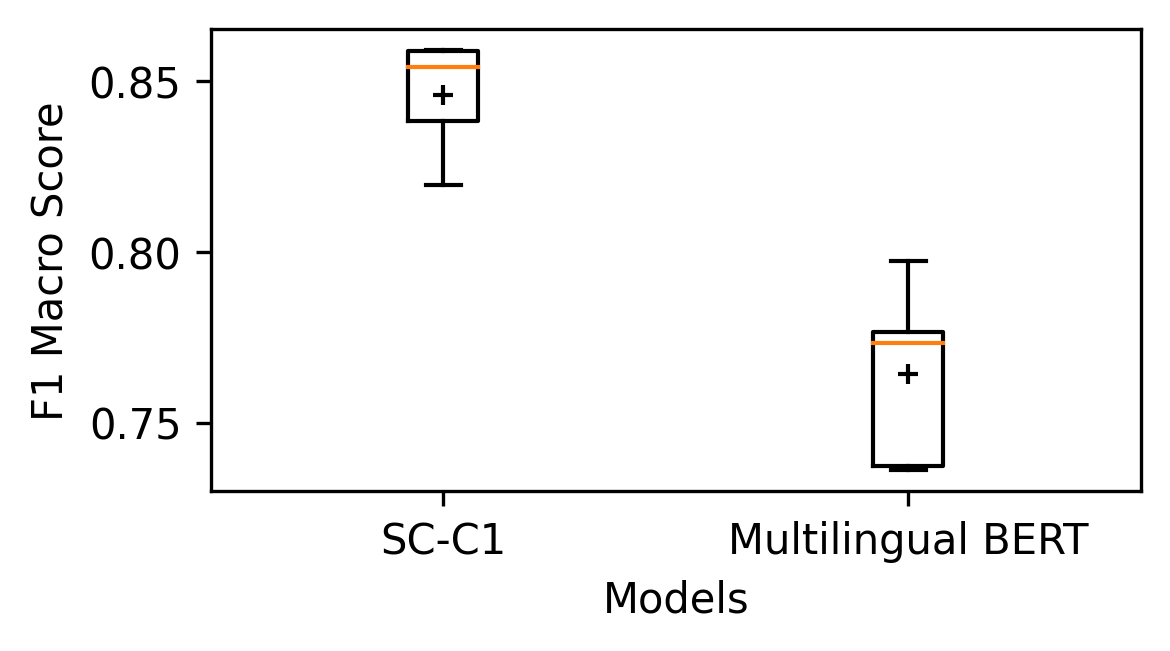

In [90]:
draw_comparison({"SC-C1":grab_f1_macro(y25_1,5),
                             "Multilingual BERT":grab_f1_macro(y25_2,5)},'F1 Macro Score',4,2)

# Monitoring

In [91]:
def train_test_sdgs_v2(model_name,dir_name,ds, epoch=2, report_to=None, save_to=None):
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    def preprocess_data(examples):
        # take a batch of texts
        text = examples["combined"]
        
        # encode them
        encoding = tokenizer(text, padding="max_length", truncation=True, max_length=128)
        # add labels
        labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
        # create numpy array of shape (batch_size, num_labels)
        labels_matrix = np.zeros((len(text), len(labels)))
        # fill numpy array
        for idx, label in enumerate(labels):
            labels_matrix[:, idx] = labels_batch[label]

        encoding["labels"] = labels_matrix.tolist()
        
        return encoding
    
    # source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
    def multi_label_metrics(predictions, labels, threshold=0.5):
        # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
        sigmoid = torch.nn.Sigmoid()
        probs = sigmoid(torch.Tensor(predictions))
        # next, use threshold to turn them into integer predictions
        y_pred = np.zeros(probs.shape)
        y_pred[np.where(probs >= threshold)] = 1
        # finally, compute metrics
        y_true = labels
        f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
        f1_macro_average = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
        roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
        accuracy = accuracy_score(y_true, y_pred)
        # return as dictionary
        metrics = {'f1_micro': f1_micro_average,
                'f1_macro': f1_macro_average,
                'roc_auc': roc_auc,
                'accuracy': accuracy}
        return metrics
    
    def compute_metrics(p: EvalPrediction):
        preds = p.predictions[0] if isinstance(p.predictions, 
                tuple) else p.predictions
        result = multi_label_metrics(
            predictions=preds, 
            labels=p.label_ids)
        return result
    
    batch_size = 64
    metric_name = "f1_macro"
    
    encoded_dataset = ds.map(preprocess_data, batched=True, remove_columns=ds['train'].column_names)
    encoded_dataset.set_format("torch")
    
    args = TrainingArguments(
        dir_name,
        evaluation_strategy = "epoch",
        save_strategy = "epoch",
        save_total_limit=1,
        learning_rate=5e-5,
        #optim='adamw_torch', 
        #lr_scheduler_type='linear',
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epoch,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model=metric_name,
        report_to=report_to,  # Use wandb for reporting
        do_train=True,
        do_eval=True,
        #push_to_hub=True,
    )
    
    model = AutoModelForSequenceClassification.from_pretrained(model_name, 
                                                        problem_type="multi_label_classification", 
                                                        num_labels=len(labels),
                                                        id2label=id2label,
                                                        label2id=label2id)
    
    trainer = Trainer(
        model,
        args,
        train_dataset=encoded_dataset["train"],
        #test_dataset=encoded_dataset["test"],
        eval_dataset=encoded_dataset["valid"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics

    )
    
   
    
    train_result_cso = trainer.train()
    
    metrics_cso = train_result_cso.metrics
    print(metrics_cso)

    data_log_cso=[]
    for elem in trainer.state.log_history:
        data_log_cso.append(elem)
        print(elem)
        
    print(len(data_log_cso))

    print("Start Evaluation")
    evaluation_result = trainer.evaluate(encoded_dataset["test"])
    print(evaluation_result)
    
    #if save_to is not None:
    #    trainer.save_model(save_to) 
    
    return evaluation_result, data_log_cso, metrics_cso

In [92]:
print('Make train/test/valid splits')
train_ind = []
valid_ind = []
test_ind = []
ind = np.arange(len(dataset))								
num = int(len(ind)*0.65)
trind = np.random.choice(ind, num, replace = False)
left = np.setdiff1d(ind, trind)
num = int(len(left)*0.1)
vind = np.random.choice(left, num, replace = False)
tind = np.setdiff1d(left, vind)
train_ind.extend(list(trind))
valid_ind.extend(list(vind))
test_ind.extend(list(tind))

Make train/test/valid splits


In [93]:
ds = DatasetDict({
    'train': dataset.select(train_ind),
    'valid': dataset.select(valid_ind),
    'test': dataset.select(test_ind)})
print(ds)

DatasetDict({
    train: Dataset({
        features: ['003.01', '003.02', '003.03', '003.04', '003.05', '003.06', '003.07', '003.08', '003.09', '003.10', '003.11', '003.12', '003.13', '003.14', '003.15', '003.16', '003.17', 'combined'],
        num_rows: 1589
    })
    valid: Dataset({
        features: ['003.01', '003.02', '003.03', '003.04', '003.05', '003.06', '003.07', '003.08', '003.09', '003.10', '003.11', '003.12', '003.13', '003.14', '003.15', '003.16', '003.17', 'combined'],
        num_rows: 85
    })
    test: Dataset({
        features: ['003.01', '003.02', '003.03', '003.04', '003.05', '003.06', '003.07', '003.08', '003.09', '003.10', '003.11', '003.12', '003.13', '003.14', '003.15', '003.16', '003.17', 'combined'],
        num_rows: 771
    })
})


In [94]:
model_name = "../../script/IndoGovBERT-final/models/persuratan-final-25/"
dir_name = "models/final_scc1"
evaluation_result, data_log_cso, metrics_cso = train_test_sdgs_v2(model_name,dir_name,ds,15,None,None)

Map:   0%|          | 0/1589 [00:00<?, ? examples/s]

Map:   0%|          | 0/85 [00:00<?, ? examples/s]

Map:   0%|          | 0/771 [00:00<?, ? examples/s]

Some weights of the model checkpoint at ../../script/IndoGovBERT-final/models/persuratan-final-25/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

  0%|          | 0/375 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/2 [00:00<?, ?it/s]

/media/agus/DATA/DDALM/venv_sdgs/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.21533629298210144, 'eval_f1_micro': 0.0, 'eval_f1_macro': 0.0, 'eval_roc_auc': 0.5, 'eval_accuracy': 0.0, 'eval_runtime': 0.1008, 'eval_samples_per_second': 842.953, 'eval_steps_per_second': 19.834, 'epoch': 1.0}


  0%|          | 0/2 [00:00<?, ?it/s]

/media/agus/DATA/DDALM/venv_sdgs/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.16499574482440948, 'eval_f1_micro': 0.3364485981308411, 'eval_f1_macro': 0.1609419991772933, 'eval_roc_auc': 0.6044117647058823, 'eval_accuracy': 0.21176470588235294, 'eval_runtime': 0.1, 'eval_samples_per_second': 849.97, 'eval_steps_per_second': 19.999, 'epoch': 2.0}


  0%|          | 0/2 [00:00<?, ?it/s]

/media/agus/DATA/DDALM/venv_sdgs/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.12155197560787201, 'eval_f1_micro': 0.6515151515151516, 'eval_f1_macro': 0.4552479815455594, 'eval_roc_auc': 0.7514705882352941, 'eval_accuracy': 0.5058823529411764, 'eval_runtime': 0.1024, 'eval_samples_per_second': 830.062, 'eval_steps_per_second': 19.531, 'epoch': 3.0}


  0%|          | 0/2 [00:00<?, ?it/s]

/media/agus/DATA/DDALM/venv_sdgs/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.09260977804660797, 'eval_f1_micro': 0.7785234899328859, 'eval_f1_macro': 0.5805408128163546, 'eval_roc_auc': 0.8389705882352941, 'eval_accuracy': 0.6823529411764706, 'eval_runtime': 0.0973, 'eval_samples_per_second': 873.368, 'eval_steps_per_second': 20.55, 'epoch': 4.0}


  0%|          | 0/2 [00:00<?, ?it/s]

/media/agus/DATA/DDALM/venv_sdgs/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.07518989592790604, 'eval_f1_micro': 0.8235294117647058, 'eval_f1_macro': 0.6212590299277606, 'eval_roc_auc': 0.86875, 'eval_accuracy': 0.7411764705882353, 'eval_runtime': 0.0854, 'eval_samples_per_second': 994.818, 'eval_steps_per_second': 23.407, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

/media/agus/DATA/DDALM/venv_sdgs/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.06671378761529922, 'eval_f1_micro': 0.8280254777070064, 'eval_f1_macro': 0.6713915771191313, 'eval_roc_auc': 0.8797794117647059, 'eval_accuracy': 0.7647058823529411, 'eval_runtime': 0.0933, 'eval_samples_per_second': 911.344, 'eval_steps_per_second': 21.443, 'epoch': 6.0}


  0%|          | 0/2 [00:00<?, ?it/s]

/media/agus/DATA/DDALM/venv_sdgs/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.06329614669084549, 'eval_f1_micro': 0.8481012658227848, 'eval_f1_macro': 0.7067298370703943, 'eval_roc_auc': 0.8919117647058823, 'eval_accuracy': 0.788235294117647, 'eval_runtime': 0.0974, 'eval_samples_per_second': 873.071, 'eval_steps_per_second': 20.543, 'epoch': 7.0}


  0%|          | 0/2 [00:00<?, ?it/s]

/media/agus/DATA/DDALM/venv_sdgs/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.058408524841070175, 'eval_f1_micro': 0.84472049689441, 'eval_f1_macro': 0.7143241347575713, 'eval_roc_auc': 0.8970588235294118, 'eval_accuracy': 0.8, 'eval_runtime': 0.1012, 'eval_samples_per_second': 839.657, 'eval_steps_per_second': 19.757, 'epoch': 8.0}


  0%|          | 0/2 [00:00<?, ?it/s]

/media/agus/DATA/DDALM/venv_sdgs/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.05506691709160805, 'eval_f1_micro': 0.8625, 'eval_f1_macro': 0.7317849515263465, 'eval_roc_auc': 0.9036764705882353, 'eval_accuracy': 0.8117647058823529, 'eval_runtime': 0.0893, 'eval_samples_per_second': 952.174, 'eval_steps_per_second': 22.404, 'epoch': 9.0}


  0%|          | 0/2 [00:00<?, ?it/s]

/media/agus/DATA/DDALM/venv_sdgs/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.05510523170232773, 'eval_f1_micro': 0.8641975308641976, 'eval_f1_macro': 0.7276925345036801, 'eval_roc_auc': 0.9091911764705882, 'eval_accuracy': 0.8235294117647058, 'eval_runtime': 0.1023, 'eval_samples_per_second': 831.105, 'eval_steps_per_second': 19.555, 'epoch': 10.0}


  0%|          | 0/2 [00:00<?, ?it/s]

/media/agus/DATA/DDALM/venv_sdgs/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.05100102722644806, 'eval_f1_micro': 0.8571428571428571, 'eval_f1_macro': 0.7239085647754377, 'eval_roc_auc': 0.9033088235294118, 'eval_accuracy': 0.8117647058823529, 'eval_runtime': 0.0895, 'eval_samples_per_second': 949.802, 'eval_steps_per_second': 22.348, 'epoch': 11.0}


  0%|          | 0/2 [00:00<?, ?it/s]

/media/agus/DATA/DDALM/venv_sdgs/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.05210593715310097, 'eval_f1_micro': 0.8588957055214724, 'eval_f1_macro': 0.7248914140555007, 'eval_roc_auc': 0.9088235294117647, 'eval_accuracy': 0.8235294117647058, 'eval_runtime': 0.1032, 'eval_samples_per_second': 824.032, 'eval_steps_per_second': 19.389, 'epoch': 12.0}


  0%|          | 0/2 [00:00<?, ?it/s]

/media/agus/DATA/DDALM/venv_sdgs/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.05113699287176132, 'eval_f1_micro': 0.8695652173913043, 'eval_f1_macro': 0.7307091257555655, 'eval_roc_auc': 0.9095588235294118, 'eval_accuracy': 0.8235294117647058, 'eval_runtime': 0.0935, 'eval_samples_per_second': 909.37, 'eval_steps_per_second': 21.397, 'epoch': 13.0}


  0%|          | 0/2 [00:00<?, ?it/s]

/media/agus/DATA/DDALM/venv_sdgs/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.051005732268095016, 'eval_f1_micro': 0.8765432098765432, 'eval_f1_macro': 0.7371262380550307, 'eval_roc_auc': 0.9154411764705883, 'eval_accuracy': 0.8352941176470589, 'eval_runtime': 0.0985, 'eval_samples_per_second': 862.654, 'eval_steps_per_second': 20.298, 'epoch': 14.0}


  0%|          | 0/2 [00:00<?, ?it/s]

/media/agus/DATA/DDALM/venv_sdgs/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.05088556930422783, 'eval_f1_micro': 0.8765432098765432, 'eval_f1_macro': 0.7404473751222977, 'eval_roc_auc': 0.9154411764705883, 'eval_accuracy': 0.8352941176470589, 'eval_runtime': 0.0997, 'eval_samples_per_second': 852.444, 'eval_steps_per_second': 20.057, 'epoch': 15.0}
{'train_runtime': 238.626, 'train_samples_per_second': 99.884, 'train_steps_per_second': 1.571, 'train_loss': 0.07539024861653645, 'epoch': 15.0}
{'train_runtime': 238.626, 'train_samples_per_second': 99.884, 'train_steps_per_second': 1.571, 'train_loss': 0.07539024861653645, 'epoch': 15.0}
{'eval_loss': 0.21533629298210144, 'eval_f1_micro': 0.0, 'eval_f1_macro': 0.0, 'eval_roc_auc': 0.5, 'eval_accuracy': 0.0, 'eval_runtime': 0.1008, 'eval_samples_per_second': 842.953, 'eval_steps_per_second': 19.834, 'epoch': 1.0, 'step': 25}
{'eval_loss': 0.16499574482440948, 'eval_f1_micro': 0.3364485981308411, 'eval_f1_macro': 0.1609419991772933, 'eval_roc_auc': 0.6044117647058823, 'eval_accuracy': 0.2117647058823

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.061967883259058, 'eval_f1_micro': 0.8388780169602087, 'eval_f1_macro': 0.7484917289033727, 'eval_roc_auc': 0.8963805393903441, 'eval_accuracy': 0.8002594033722439, 'eval_runtime': 0.7016, 'eval_samples_per_second': 1098.948, 'eval_steps_per_second': 18.53, 'epoch': 15.0}


In [95]:
model_name = "bert-base-multilingual-uncased"
dir_name = "models/final_multilingual"
evaluation_result_multi, data_log_multi, metrics_cso_multi = train_test_sdgs_v2(model_name,dir_name,ds,15,None,None)

Map:   0%|          | 0/1589 [00:00<?, ? examples/s]

Map:   0%|          | 0/85 [00:00<?, ? examples/s]

Map:   0%|          | 0/771 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingu

  0%|          | 0/375 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/2 [00:00<?, ?it/s]

/media/agus/DATA/DDALM/venv_sdgs/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.2534210979938507, 'eval_f1_micro': 0.0, 'eval_f1_macro': 0.0, 'eval_roc_auc': 0.5, 'eval_accuracy': 0.0, 'eval_runtime': 0.0868, 'eval_samples_per_second': 978.818, 'eval_steps_per_second': 23.031, 'epoch': 1.0}


  0%|          | 0/2 [00:00<?, ?it/s]

/media/agus/DATA/DDALM/venv_sdgs/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.21618470549583435, 'eval_f1_micro': 0.0, 'eval_f1_macro': 0.0, 'eval_roc_auc': 0.5, 'eval_accuracy': 0.0, 'eval_runtime': 0.0879, 'eval_samples_per_second': 966.605, 'eval_steps_per_second': 22.744, 'epoch': 2.0}


  0%|          | 0/2 [00:00<?, ?it/s]

/media/agus/DATA/DDALM/venv_sdgs/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.19751717150211334, 'eval_f1_micro': 0.0, 'eval_f1_macro': 0.0, 'eval_roc_auc': 0.5, 'eval_accuracy': 0.0, 'eval_runtime': 0.104, 'eval_samples_per_second': 817.474, 'eval_steps_per_second': 19.235, 'epoch': 3.0}


  0%|          | 0/2 [00:00<?, ?it/s]

/media/agus/DATA/DDALM/venv_sdgs/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.17676852643489838, 'eval_f1_micro': 0.22916666666666669, 'eval_f1_macro': 0.10073048827374087, 'eval_roc_auc': 0.5647058823529412, 'eval_accuracy': 0.12941176470588237, 'eval_runtime': 0.0891, 'eval_samples_per_second': 953.452, 'eval_steps_per_second': 22.434, 'epoch': 4.0}


  0%|          | 0/2 [00:00<?, ?it/s]

/media/agus/DATA/DDALM/venv_sdgs/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.1494709998369217, 'eval_f1_micro': 0.3888888888888889, 'eval_f1_macro': 0.1739562810770241, 'eval_roc_auc': 0.6227941176470588, 'eval_accuracy': 0.24705882352941178, 'eval_runtime': 0.1099, 'eval_samples_per_second': 773.18, 'eval_steps_per_second': 18.192, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

/media/agus/DATA/DDALM/venv_sdgs/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.12978555262088776, 'eval_f1_micro': 0.5691056910569107, 'eval_f1_macro': 0.27266361089890495, 'eval_roc_auc': 0.7047794117647058, 'eval_accuracy': 0.4117647058823529, 'eval_runtime': 0.099, 'eval_samples_per_second': 858.2, 'eval_steps_per_second': 20.193, 'epoch': 6.0}


  0%|          | 0/2 [00:00<?, ?it/s]

/media/agus/DATA/DDALM/venv_sdgs/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.11316317319869995, 'eval_f1_micro': 0.7153284671532847, 'eval_f1_macro': 0.44824142247198157, 'eval_roc_auc': 0.7871323529411764, 'eval_accuracy': 0.5764705882352941, 'eval_runtime': 0.0876, 'eval_samples_per_second': 969.776, 'eval_steps_per_second': 22.818, 'epoch': 7.0}


  0%|          | 0/2 [00:00<?, ?it/s]

/media/agus/DATA/DDALM/venv_sdgs/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.09813302010297775, 'eval_f1_micro': 0.7746478873239437, 'eval_f1_macro': 0.5338321293429653, 'eval_roc_auc': 0.8227941176470588, 'eval_accuracy': 0.6470588235294118, 'eval_runtime': 0.0938, 'eval_samples_per_second': 906.33, 'eval_steps_per_second': 21.325, 'epoch': 8.0}


  0%|          | 0/2 [00:00<?, ?it/s]

/media/agus/DATA/DDALM/venv_sdgs/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.0905916690826416, 'eval_f1_micro': 0.832214765100671, 'eval_f1_macro': 0.5927979485255027, 'eval_roc_auc': 0.8639705882352942, 'eval_accuracy': 0.7294117647058823, 'eval_runtime': 0.1059, 'eval_samples_per_second': 802.29, 'eval_steps_per_second': 18.877, 'epoch': 9.0}


  0%|          | 0/2 [00:00<?, ?it/s]

/media/agus/DATA/DDALM/venv_sdgs/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.08642278611660004, 'eval_f1_micro': 0.8181818181818181, 'eval_f1_macro': 0.5844275091953111, 'eval_roc_auc': 0.8683823529411765, 'eval_accuracy': 0.7411764705882353, 'eval_runtime': 0.0871, 'eval_samples_per_second': 975.542, 'eval_steps_per_second': 22.954, 'epoch': 10.0}


  0%|          | 0/2 [00:00<?, ?it/s]

/media/agus/DATA/DDALM/venv_sdgs/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.07886392623186111, 'eval_f1_micro': 0.8366013071895425, 'eval_f1_macro': 0.6178550207961973, 'eval_roc_auc': 0.875, 'eval_accuracy': 0.7529411764705882, 'eval_runtime': 0.09, 'eval_samples_per_second': 943.993, 'eval_steps_per_second': 22.212, 'epoch': 11.0}


  0%|          | 0/2 [00:00<?, ?it/s]

/media/agus/DATA/DDALM/venv_sdgs/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.07724554091691971, 'eval_f1_micro': 0.8500000000000001, 'eval_f1_macro': 0.6791618608227604, 'eval_roc_auc': 0.8974264705882353, 'eval_accuracy': 0.8, 'eval_runtime': 0.0991, 'eval_samples_per_second': 857.465, 'eval_steps_per_second': 20.176, 'epoch': 12.0}


  0%|          | 0/2 [00:00<?, ?it/s]

/media/agus/DATA/DDALM/venv_sdgs/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.07268685102462769, 'eval_f1_micro': 0.8518518518518517, 'eval_f1_macro': 0.6736185383244206, 'eval_roc_auc': 0.9029411764705882, 'eval_accuracy': 0.8117647058823529, 'eval_runtime': 0.0917, 'eval_samples_per_second': 927.01, 'eval_steps_per_second': 21.812, 'epoch': 13.0}


  0%|          | 0/2 [00:00<?, ?it/s]

/media/agus/DATA/DDALM/venv_sdgs/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.0703679546713829, 'eval_f1_micro': 0.8695652173913043, 'eval_f1_macro': 0.6932870019557326, 'eval_roc_auc': 0.9095588235294118, 'eval_accuracy': 0.8235294117647058, 'eval_runtime': 0.1046, 'eval_samples_per_second': 812.412, 'eval_steps_per_second': 19.116, 'epoch': 14.0}


  0%|          | 0/2 [00:00<?, ?it/s]

/media/agus/DATA/DDALM/venv_sdgs/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


{'eval_loss': 0.06954275071620941, 'eval_f1_micro': 0.8734177215189873, 'eval_f1_macro': 0.7011883541295305, 'eval_roc_auc': 0.9044117647058824, 'eval_accuracy': 0.8117647058823529, 'eval_runtime': 0.1125, 'eval_samples_per_second': 755.284, 'eval_steps_per_second': 17.771, 'epoch': 15.0}
{'train_runtime': 298.8744, 'train_samples_per_second': 79.749, 'train_steps_per_second': 1.255, 'train_loss': 0.13589774576822916, 'epoch': 15.0}
{'train_runtime': 298.8744, 'train_samples_per_second': 79.749, 'train_steps_per_second': 1.255, 'train_loss': 0.13589774576822916, 'epoch': 15.0}
{'eval_loss': 0.2534210979938507, 'eval_f1_micro': 0.0, 'eval_f1_macro': 0.0, 'eval_roc_auc': 0.5, 'eval_accuracy': 0.0, 'eval_runtime': 0.0868, 'eval_samples_per_second': 978.818, 'eval_steps_per_second': 23.031, 'epoch': 1.0, 'step': 25}
{'eval_loss': 0.21618470549583435, 'eval_f1_micro': 0.0, 'eval_f1_macro': 0.0, 'eval_roc_auc': 0.5, 'eval_accuracy': 0.0, 'eval_runtime': 0.0879, 'eval_samples_per_second': 966

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.07968772202730179, 'eval_f1_micro': 0.8398671096345515, 'eval_f1_macro': 0.7186161722625632, 'eval_roc_auc': 0.8902306317716465, 'eval_accuracy': 0.7859922178988327, 'eval_runtime': 0.6931, 'eval_samples_per_second': 1112.357, 'eval_steps_per_second': 18.756, 'epoch': 15.0}


In [96]:
data_log_multi

[{'eval_loss': 0.2534210979938507,
  'eval_f1_micro': 0.0,
  'eval_f1_macro': 0.0,
  'eval_roc_auc': 0.5,
  'eval_accuracy': 0.0,
  'eval_runtime': 0.0868,
  'eval_samples_per_second': 978.818,
  'eval_steps_per_second': 23.031,
  'epoch': 1.0,
  'step': 25},
 {'eval_loss': 0.21618470549583435,
  'eval_f1_micro': 0.0,
  'eval_f1_macro': 0.0,
  'eval_roc_auc': 0.5,
  'eval_accuracy': 0.0,
  'eval_runtime': 0.0879,
  'eval_samples_per_second': 966.605,
  'eval_steps_per_second': 22.744,
  'epoch': 2.0,
  'step': 50},
 {'eval_loss': 0.19751717150211334,
  'eval_f1_micro': 0.0,
  'eval_f1_macro': 0.0,
  'eval_roc_auc': 0.5,
  'eval_accuracy': 0.0,
  'eval_runtime': 0.104,
  'eval_samples_per_second': 817.474,
  'eval_steps_per_second': 19.235,
  'epoch': 3.0,
  'step': 75},
 {'eval_loss': 0.17676852643489838,
  'eval_f1_micro': 0.22916666666666669,
  'eval_f1_macro': 0.10073048827374087,
  'eval_roc_auc': 0.5647058823529412,
  'eval_accuracy': 0.12941176470588237,
  'eval_runtime': 0.0891,

In [111]:
def extract_metric(data, metric):
    return [d.get(metric, None) for d in data if metric in d]


epochs = range(1, len(data_log_cso) )

f1_micro_data1 = [x for x in extract_metric(data_log_cso, 'eval_f1_micro') if x is not None]
f1_micro_data2 = [x for x in extract_metric(data_log_multi, 'eval_f1_micro') if x is not None]

f1_macro_data1 = [x for x in extract_metric(data_log_cso, 'eval_f1_macro') if x is not None]
f1_macro_data2 = [x for x in extract_metric(data_log_multi, 'eval_f1_macro') if x is not None]



In [112]:
print(len(epochs), len(f1_micro_data1), len(f1_micro_data2), len(f1_macro_data1), len(f1_macro_data2))


15 15 15 15 15


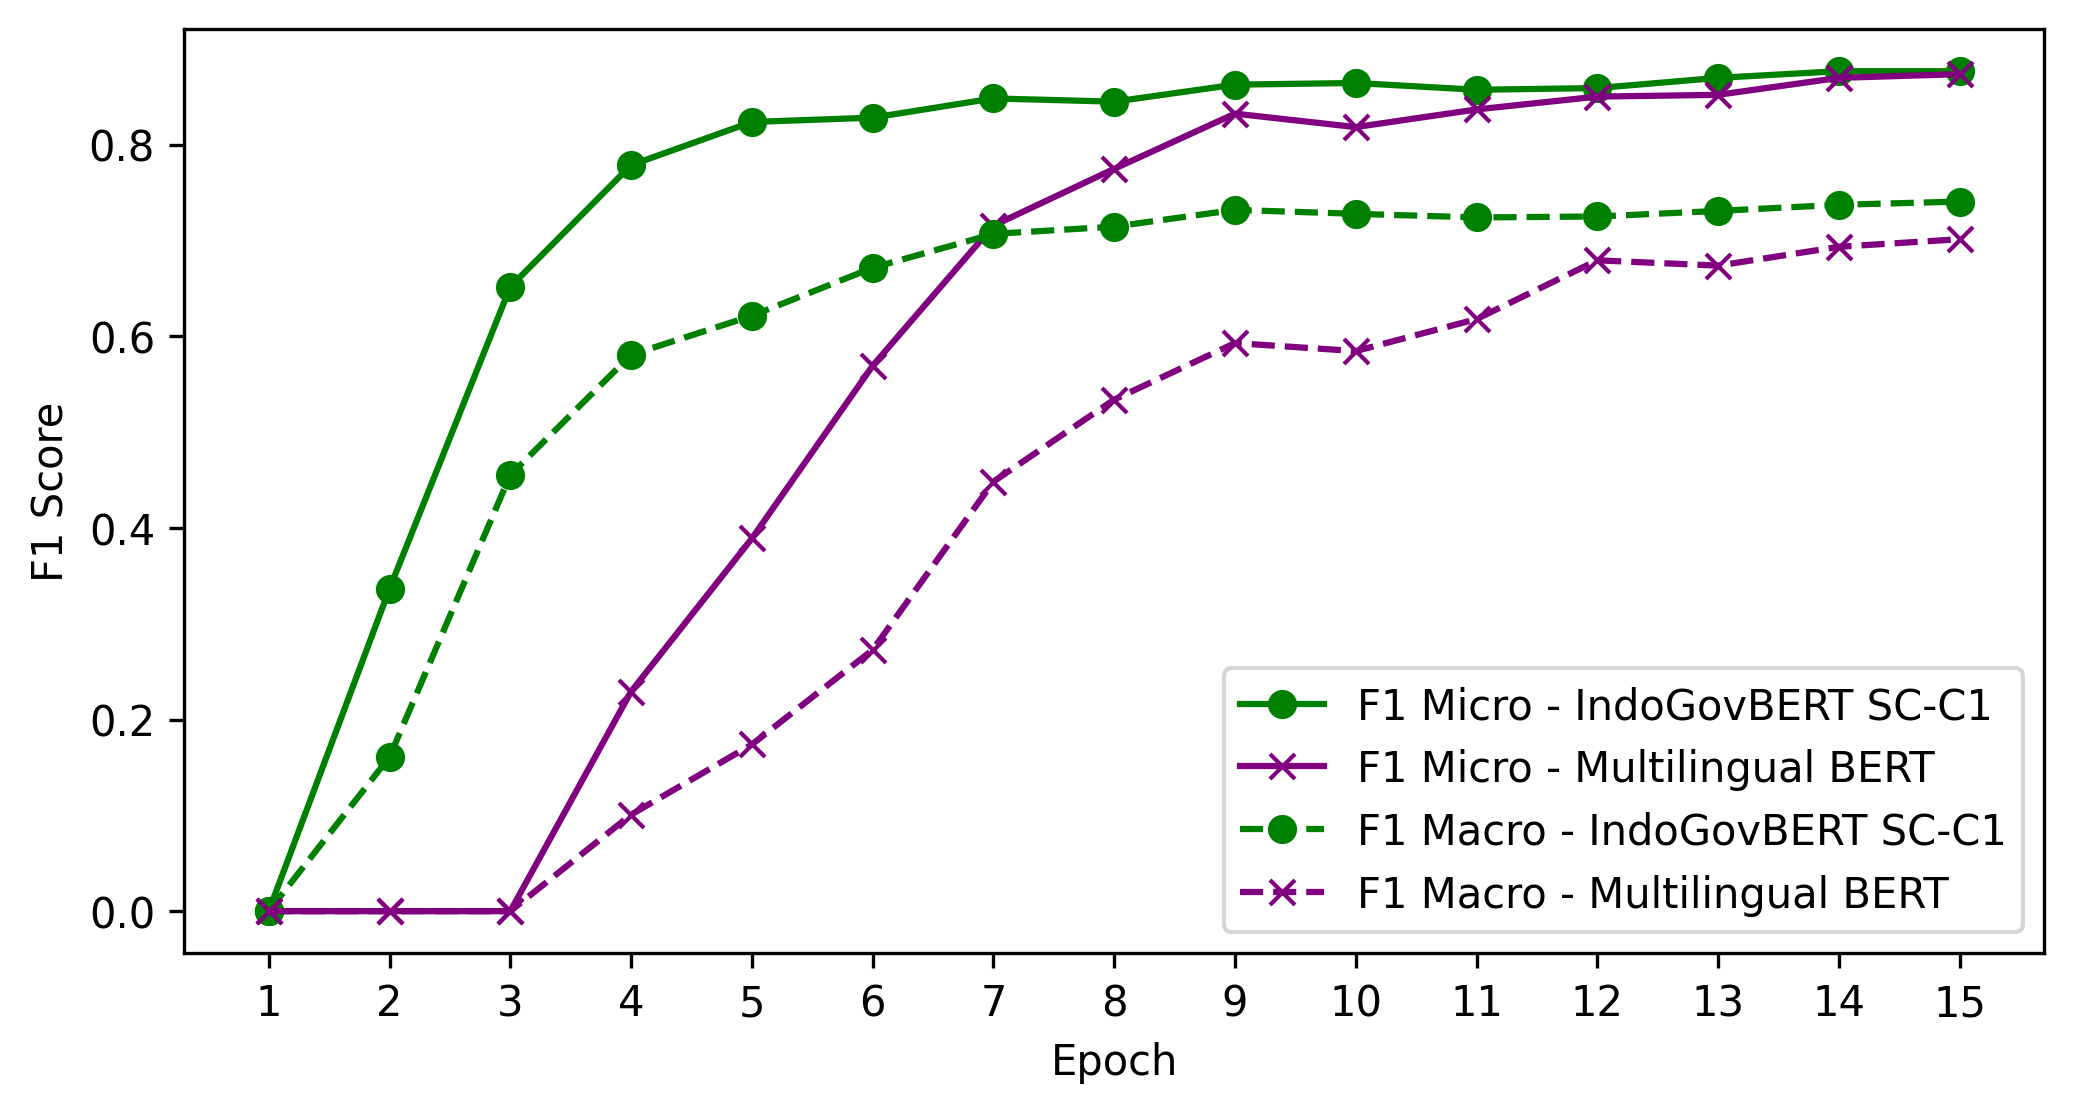

In [119]:
plt.figure(figsize=(8, 4), dpi=300)

plt.plot(epochs, f1_micro_data1, label='F1 Micro - IndoGovBERT SC-C1', color='green', marker='o')
plt.plot(epochs, f1_micro_data2, label='F1 Micro - Multilingual BERT', color='purple', marker='x')

plt.plot(epochs, f1_macro_data1, label='F1 Macro - IndoGovBERT SC-C1', color='green', linestyle='--', marker='o')
plt.plot(epochs, f1_macro_data2, label='F1 Macro - Multilingual BERT', color='purple', linestyle='--', marker='x')

plt.xlabel('Epoch')
plt.ylabel('F1 Score')
#plt.title('F1 Micro and F1 Macro Scores Comparison')
plt.legend()
#plt.grid(True)
plt.xticks(epochs)
plt.show()


In [120]:
metrics_cso

{'train_runtime': 238.626,
 'train_samples_per_second': 99.884,
 'train_steps_per_second': 1.571,
 'train_loss': 0.07539024861653645,
 'epoch': 15.0}

In [121]:
metrics_cso_multi

{'train_runtime': 298.8744,
 'train_samples_per_second': 79.749,
 'train_steps_per_second': 1.255,
 'train_loss': 0.13589774576822916,
 'epoch': 15.0}

In [131]:
from transformers import BertModel, BertConfig

# Initialize a BERT model
def print_parameter(model_name):
    # Load the BERT model configuration
    config = BertConfig.from_pretrained(model_name)

    # Load the BERT model
    model = BertModel(config)

    # Access the model parameters
    params = model.parameters()

    # Count the parameters
    num_params = sum(p.numel() for p in params if p.requires_grad)
    print("Number of trainable parameters:", num_params)


In [132]:
print_parameter("bert-base-multilingual-uncased")

Number of trainable parameters: 167356416


In [133]:
print_parameter("../../script/IndoGovBERT-final/models/persuratan-final-25/")


Number of trainable parameters: 124441344


In [130]:
from transformers import BertModel, BertConfig

# Load the BERT model configuration
config = BertConfig.from_pretrained("../../script/IndoGovBERT-final/models/persuratan-final-25/")

# Load the BERT model
model = BertModel(config)

# Access the model parameters
params = model.parameters()

# Count the parameters
num_params = sum(p.numel() for p in params if p.requires_grad)
print("Number of trainable parameters:", num_params)


Number of trainable parameters: 124441344
